In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Add the root directory of the package to sys.path
sys.path.append('/Users/zzhang/Workspace/SpyDust/')
sys.path.append('../')

from SpyDust.Grain import *

l_a computed
readPAH computed
Loaded previously computed Jpeisrf arrays from file.
Tev table already exists at /Users/zzhang/Workspace/SpyDust/SpyDust/Data_Files/Tev_30a_30chi.txt.
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
Gaunt factor stored


/Users/zzhang/Workspace/SpyDust/SpyDust/free_free.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(gff_data_file, delim_whitespace=True, comment=';', header=None, names=['gamma2', 'u', 'gff'])


In [46]:
CNM_params = {'nh' : 30, 'T': 100., 'Chi': 1, 'xh': 1.2e-3, 'xC': 3e-4, 'y' : 0, 'gamma': 0, 'dipole': 9.3, 'line':7}

grain_obj = grain_distribution()
f_a_beta = grain_obj.shape_and_size_dist(6, a_weighted=False, normalize=True)

a_tab = grain_obj.a_tab
a_dist = grain_obj.a_dist

# Import the a2 parameter from grainparams or define it explicitly

a_disk = a_tab[a_tab <= a2]
a_sphere = a_tab[a_tab > a2]

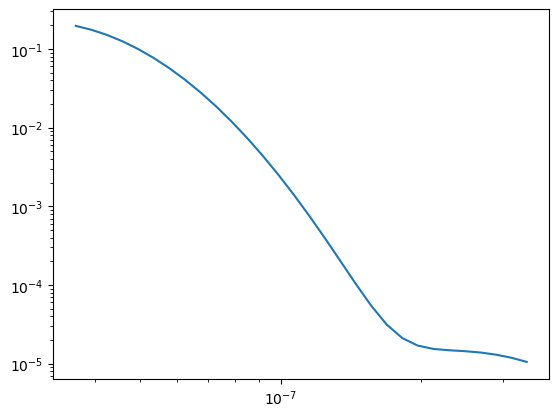

In [48]:
plt.loglog(a_tab, a_dist, label='a_dist')

- How given-size SED varies with respect to the grain size? 


In [ ]:
from scipy.optimize import curve_fit
from scipy import stats

def lognormal_sed_fit(freqs, sed, initial_guess=None, return_fit_curve=False, thres=1e-6):
    """
    Fit a log-normal model to SED data to extract peak frequency and width.
    
    The log-normal model used is:
    SED(f) = A * exp(-0.5 * ((ln(f) - ln(f_peak)) / sigma)^2)
    
    where:
    - f_peak is the peak frequency
    - sigma is the width parameter in log space
    - A is the amplitude
    
    Parameters:
    -----------
    freqs : array_like
        1D array of frequencies
    sed : array_like
        1D array of SED values corresponding to freqs
    initial_guess : tuple, optional
        Initial guess for (amplitude, log_f_peak, sigma)
        If None, will estimate from data
    return_fit_curve : bool, optional
        If True, also return the fitted curve values
    thres : float, optional
        Threshold parameter. Points with SED < thres * max(SED) are masked as invalid.
        Default is 1e-6.
    
    Returns:
    --------
    f_peak : float
        Peak frequency of the fitted log-normal
    sigma : float
        Width parameter in log space
    fit_params : tuple
        Full fitting parameters (amplitude, log_f_peak, sigma)
    fit_curve : array_like (only if return_fit_curve=True)
        Fitted SED values at input frequencies
    fit_quality : dict
        Dictionary containing R-squared and other fit quality metrics
    """
    
    # Convert to numpy arrays
    freqs = np.asarray(freqs)
    sed = np.asarray(sed)
    
    # Calculate threshold value
    sed_max = np.max(sed)
    threshold_value = thres * sed_max
    
    # Remove any non-positive values and points below threshold
    valid_mask = (freqs > 0) & (sed > 0) & np.isfinite(freqs) & np.isfinite(sed) & (sed >= threshold_value)
    freqs_clean = freqs[valid_mask]
    sed_clean = sed[valid_mask]
    
    if len(freqs_clean) < 3:
        raise ValueError(f"Need at least 3 valid data points for fitting. Only {len(freqs_clean)} points above threshold {threshold_value:.2e}")
    
    # Define log-normal function in linear space
    def lognormal_func(f, amplitude, log_f_peak, sigma):
        log_f = np.log(f)
        return amplitude * np.exp(-0.5 * ((log_f - log_f_peak) / sigma)**2)
    
    # Estimate initial parameters if not provided
    if initial_guess is None:
        # Find approximate peak
        peak_idx = np.argmax(sed_clean)
        f_peak_est = freqs_clean[peak_idx]
        amplitude_est = sed_clean[peak_idx]
        
        # Estimate width from FWHM
        half_max = amplitude_est / 2
        # Find points closest to half maximum
        left_idx = np.argmin(np.abs(sed_clean[:peak_idx] - half_max)) if peak_idx > 0 else 0
        right_idx = peak_idx + np.argmin(np.abs(sed_clean[peak_idx:] - half_max))
        
        if right_idx > left_idx:
            fwhm_freq = freqs_clean[right_idx] - freqs_clean[left_idx]
            # Convert FWHM to sigma for log-normal (approximate)
            sigma_est = np.log(1 + fwhm_freq / f_peak_est) / (2 * np.sqrt(2 * np.log(2)))
        else:
            sigma_est = 0.5  # Default fallback
        
        initial_guess = (amplitude_est, np.log(f_peak_est), sigma_est)
    
    try:
        # Perform the fit
        popt, pcov = curve_fit(lognormal_func, freqs_clean, sed_clean, 
                              p0=initial_guess, maxfev=5000)
        
        amplitude_fit, log_f_peak_fit, sigma_fit = popt
        f_peak = np.exp(log_f_peak_fit)
        
        # Calculate fit quality metrics
        sed_fit = lognormal_func(freqs_clean, *popt)
        ss_res = np.sum((sed_clean - sed_fit)**2)
        ss_tot = np.sum((sed_clean - np.mean(sed_clean))**2)
        r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        
        # Calculate parameter uncertainties
        param_errors = np.sqrt(np.diag(pcov))
        f_peak_error = f_peak * param_errors[1]  # Error propagation for exp(log_f_peak)
        
        fit_quality = {
            'r_squared': r_squared,
            'residual_sum_squares': ss_res,
            'f_peak_error': f_peak_error,
            'sigma_error': param_errors[2],
            'amplitude_error': param_errors[0],
            'covariance_matrix': pcov,
            'n_points_used': len(freqs_clean),
            'threshold_value': threshold_value
        }
        
        if return_fit_curve:
            # Return fit curve at original frequency points
            fit_curve_full = np.full_like(freqs, np.nan)
            fit_curve_full[valid_mask] = sed_fit
            return f_peak, sigma_fit, popt, fit_curve_full, fit_quality
        else:
            return f_peak, sigma_fit, popt, fit_quality
            
    except Exception as e:
        raise RuntimeError(f"Fitting failed: {str(e)}")
    
    
def measure_sed_peak_properties(freqs, sed, plot=False, save_path=None, thres=1e-6, title='SED fit:'):
    """
    Convenience function to measure peak properties of an SED using log-normal fitting.
    
    Parameters:
    -----------
    freqs : array_like
        Frequency array
    sed : array_like  
        SED values
    plot : bool, optional
        If True, create a plot showing the fit
    save_path : str, optional
        Path to save the plot
    thres : float, optional
        Threshold parameter. Points with SED < thres * max(SED) are masked as invalid.
        Default is 1e-6.
        
    Returns:
    --------
    results : dict
        Dictionary containing:
        - 'f_peak': peak frequency
        - 'sigma': width parameter
        - 'fwhm': full width at half maximum
        - 'r_squared': fit quality
    """
    
    f_peak, sigma, fit_params, fit_quality = lognormal_sed_fit(freqs, sed, thres=thres)
    
    # Calculate FWHM from sigma
    # For log-normal: FWHM ≈ f_peak * (exp(sigma*sqrt(2*ln(2))) - exp(-sigma*sqrt(2*ln(2))))
    fwhm_factor = np.sqrt(2 * np.log(2))
    fwhm = f_peak * (np.exp(sigma * fwhm_factor) - np.exp(-sigma * fwhm_factor))
    
    results = {
        'f_peak': f_peak,
        'sigma': sigma,
        'fwhm': fwhm,
        'r_squared': fit_quality['r_squared'],
        'amplitude': fit_params[0],
        'f_peak_error': fit_quality['f_peak_error'],
        'sigma_error': fit_quality['sigma_error'],
        'n_points_used': fit_quality['n_points_used'],
        'threshold_value': fit_quality['threshold_value']
    }
    
    if plot:
        fig = plt.figure(figsize=(10, 6))
        ax1 = fig.add_subplot(111)

        # Main plot
        f_peak_plot = f_peak
        
        ax1.loglog(freqs, sed, 'o-', label='Data', alpha=0.7)
        
        # Show threshold line
        # ax1.axhline(y=fit_quality['threshold_value'], color='gray', linestyle=':', 
        #            alpha=0.5, label=f'Threshold ({thres:.0e}×max)')
        ax1.set_ylim(fit_quality['threshold_value'], max(sed) * 10)
        
        # Generate smooth fit curve for plotting
        freq_smooth = np.logspace(np.log10(freqs.min()), np.log10(freqs.max()), 200)
        _, _, _, fit_smooth, _ = lognormal_sed_fit(freqs, sed, return_fit_curve=True, thres=thres)
        
        # Interpolate fit for smooth curve
        from scipy.interpolate import interp1d
        valid_mask = np.isfinite(fit_smooth)
        if np.sum(valid_mask) > 1:
            interp_func = interp1d(freqs[valid_mask], fit_smooth[valid_mask], 
                                 kind='linear', bounds_error=False, fill_value=np.nan)
            fit_smooth_plot = interp_func(freq_smooth)
            ax1.loglog(freq_smooth, fit_smooth_plot, '--', label='Log-normal fit', linewidth=2)
        
        ax1.axvline(f_peak_plot, color='red', linestyle=':', alpha=0.8, 
                   label=f'Peak')
        ax1.set_xlabel('Frequency [GHz]')
        ax1.set_ylabel('SED [Jy]')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_title(f'{title}, f_peak = {f_peak_plot:.3f} GHz, σ = {sigma:.3f}')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        plt.show()
    
    return results



In [19]:
from SpyDust.SpyDust import SpyDust_given_grain_size_shape

# log-normal fit the SED of given grain size
def sizeSED_lognormal_fitting(a, 
                              beta,
                              environment=CNM_params,
                              threshold=1e-3, # The range of SED values to consider (1e-3 * max(SED) , max(SED))
                              min_freq=None, 
                              max_freq=None, 
                              n_freq=None, 
                              save_path=None):
    """
    Demonstrate the log-normal fitting function with example data
    """

    result = SpyDust_given_grain_size_shape(environment, 
                                            a, beta, 
                                            tumbling=True, 
                                            min_freq=min_freq, 
                                            max_freq=max_freq, 
                                            n_freq=n_freq)

    freqs_GHz = result[0, :]
    sed_values = result[1, :]
    
    # Test the fitting function
    try:
        results = measure_sed_peak_properties(freqs_GHz, sed_values, plot=True, save_path=save_path, thres=threshold, title=f'a={a:.3e} cm, β={beta:.3f}')

        print("Fitting results:")
        print(f"Fitted peak frequency: {results['f_peak']:.2e} ± {results['f_peak_error']:.2e} Hz")
        print(f"Fitted sigma: {results['sigma']:.3f} ± {results['sigma_error']:.3f}")
        print(f"FWHM: {results['fwhm']:.2e} Hz")
        print(f"R-squared: {results['r_squared']:.4f}")
        
    except Exception as e:
        print(f"Error in fitting: {e}")

    return results['f_peak'], results['sigma']

In [9]:
def eval_beta_d(a):
    if a <= a2:
        beta_val = cylindrical_params(a, d)[1]
    else:
        beta_val=0

    return beta_val

    
def eval_beta_2d(a):
    if a <= a2:
        beta_val = cylindrical_params(a, 2*d)[1]
    else:
        beta_val=0

    return beta_val

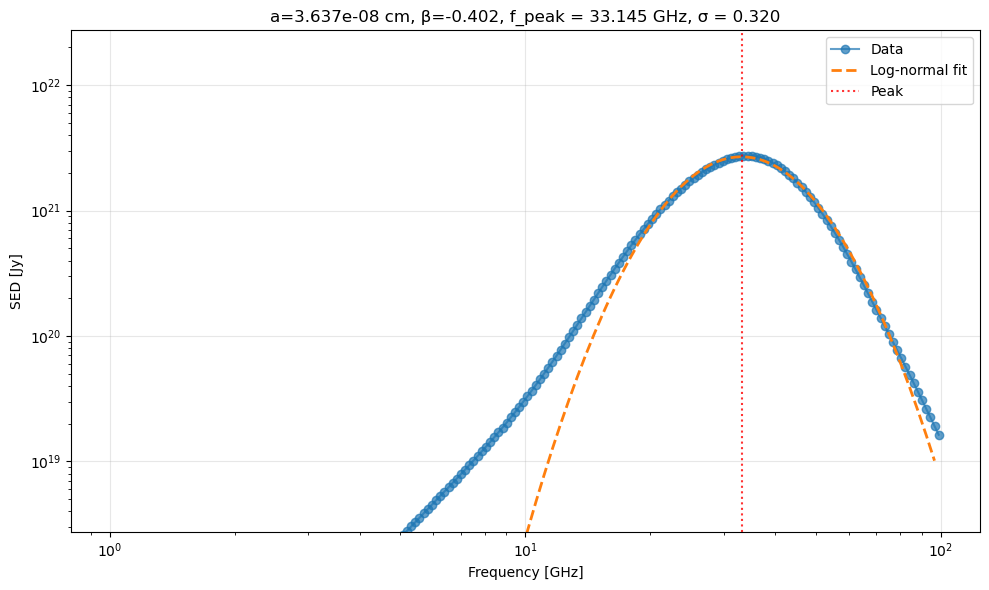

Fitting results:
Fitted peak frequency: 3.31e+01 ± 6.08e-02 Hz
Fitted sigma: 0.320 ± 0.002
FWHM: 2.56e+01 Hz
R-squared: 0.9966


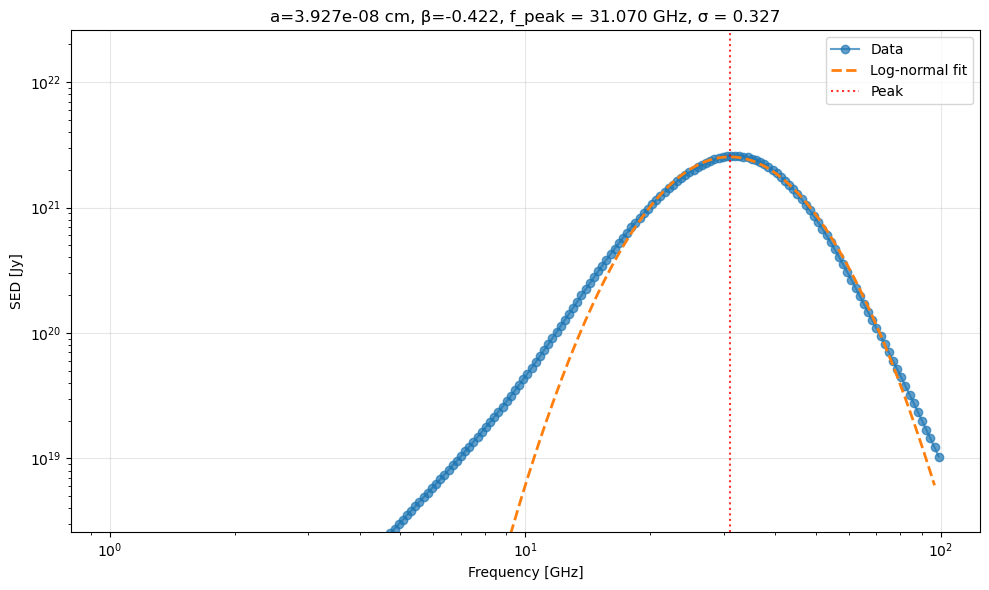

Fitting results:
Fitted peak frequency: 3.11e+01 ± 5.98e-02 Hz
Fitted sigma: 0.327 ± 0.002
FWHM: 2.45e+01 Hz
R-squared: 0.9963


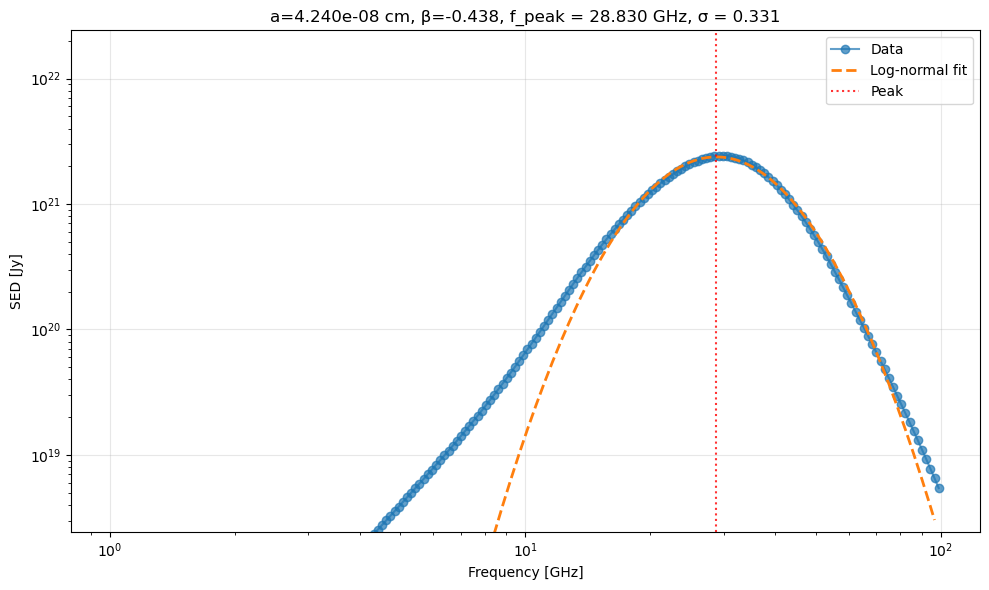

Fitting results:
Fitted peak frequency: 2.88e+01 ± 5.79e-02 Hz
Fitted sigma: 0.331 ± 0.002
FWHM: 2.31e+01 Hz
R-squared: 0.9960


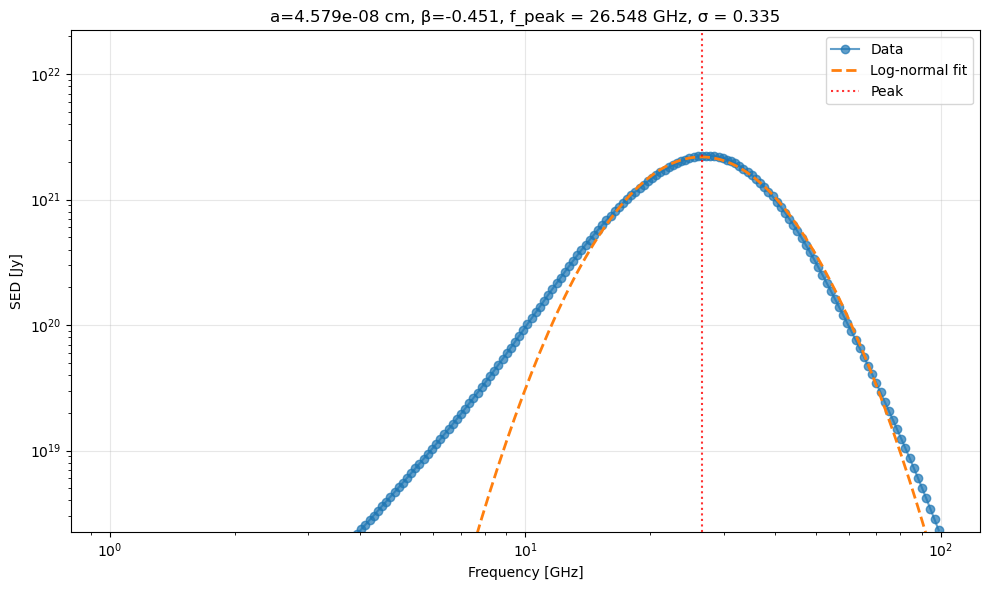

Fitting results:
Fitted peak frequency: 2.65e+01 ± 5.53e-02 Hz
Fitted sigma: 0.335 ± 0.002
FWHM: 2.15e+01 Hz
R-squared: 0.9957


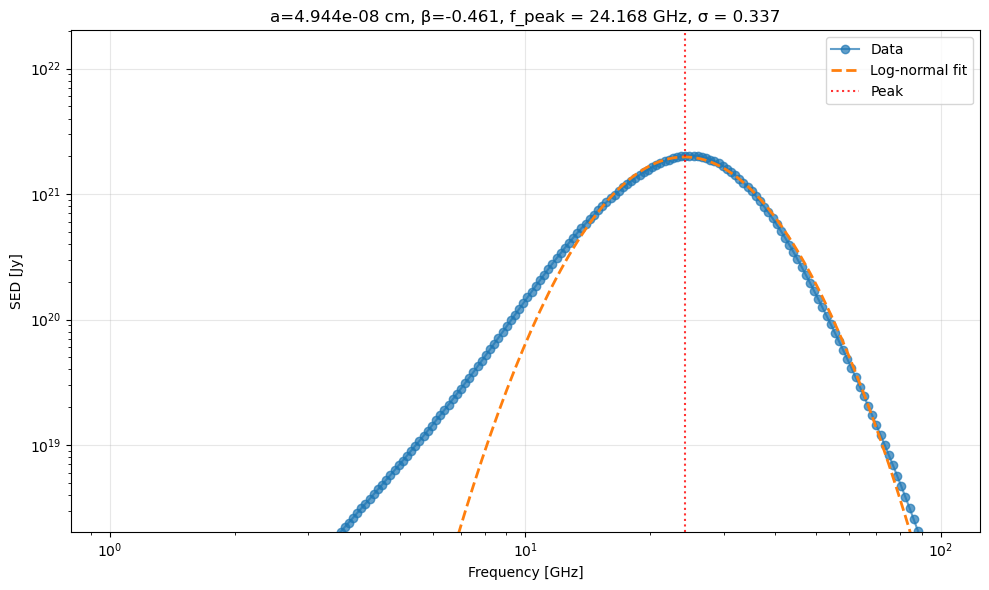

Fitting results:
Fitted peak frequency: 2.42e+01 ± 5.30e-02 Hz
Fitted sigma: 0.337 ± 0.002
FWHM: 1.97e+01 Hz
R-squared: 0.9953


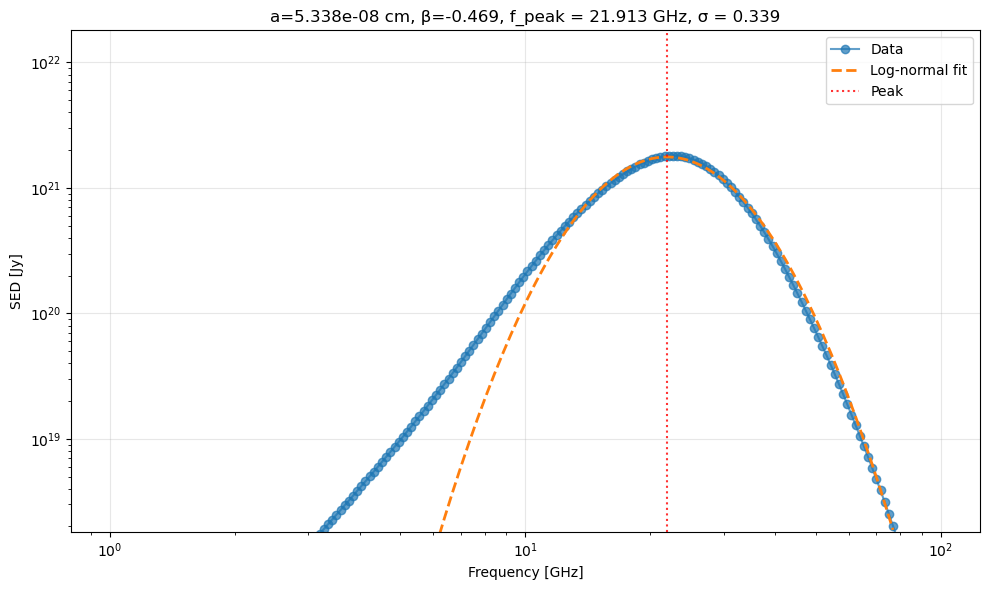

Fitting results:
Fitted peak frequency: 2.19e+01 ± 5.12e-02 Hz
Fitted sigma: 0.339 ± 0.002
FWHM: 1.79e+01 Hz
R-squared: 0.9947


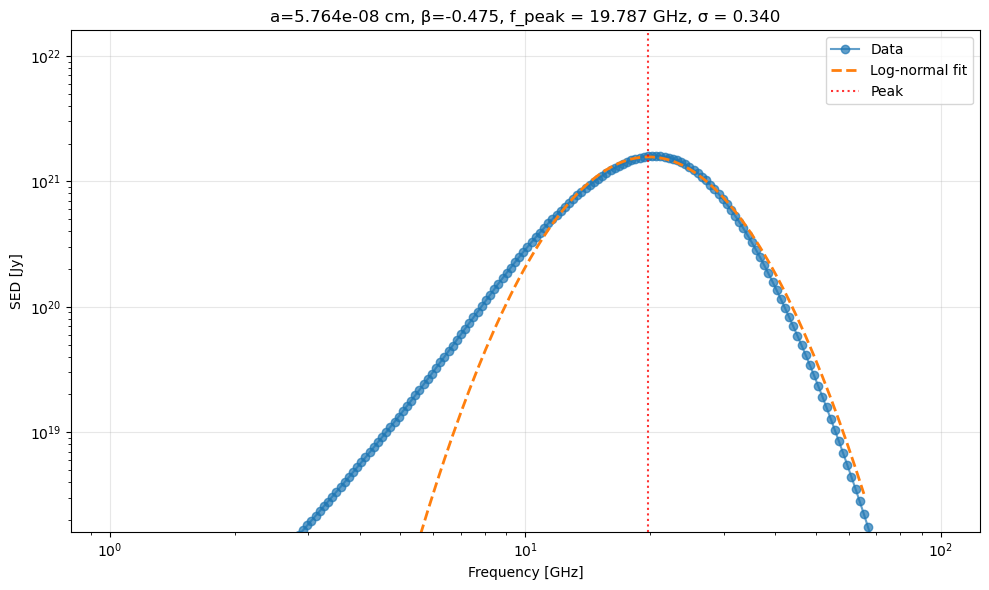

Fitting results:
Fitted peak frequency: 1.98e+01 ± 4.94e-02 Hz
Fitted sigma: 0.340 ± 0.002
FWHM: 1.62e+01 Hz
R-squared: 0.9940


In [20]:
peak_disk_d = []
sigma_disk_d = []

for (a, i) in zip(a_disk, range(len(a_disk))):
    beta = eval_beta_d(a)
    pfreq, sigma = sizeSED_lognormal_fitting(a, beta, save_path=f'figures/discSED_d_{i}.pdf')
    peak_disk_d.append(pfreq)
    sigma_disk_d.append(sigma)

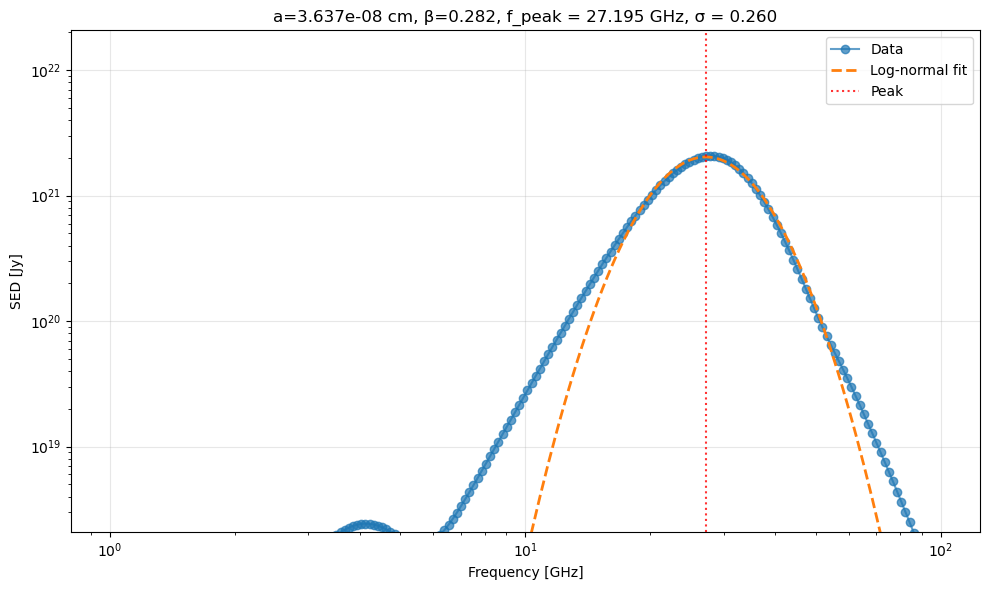

Fitting results:
Fitted peak frequency: 2.72e+01 ± 5.32e-02 Hz
Fitted sigma: 0.260 ± 0.002
FWHM: 1.69e+01 Hz
R-squared: 0.9948


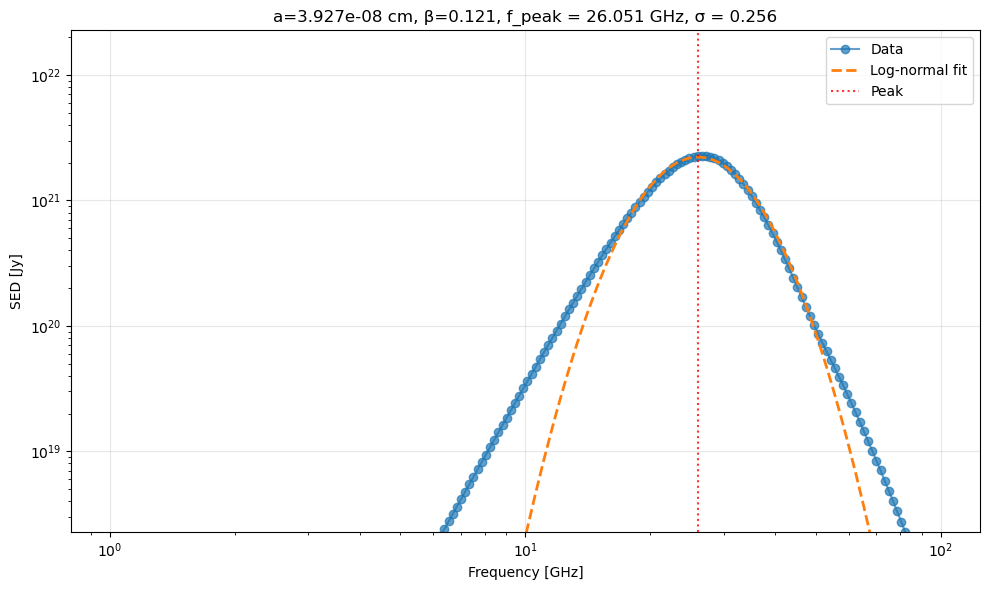

Fitting results:
Fitted peak frequency: 2.61e+01 ± 5.08e-02 Hz
Fitted sigma: 0.256 ± 0.002
FWHM: 1.60e+01 Hz
R-squared: 0.9950


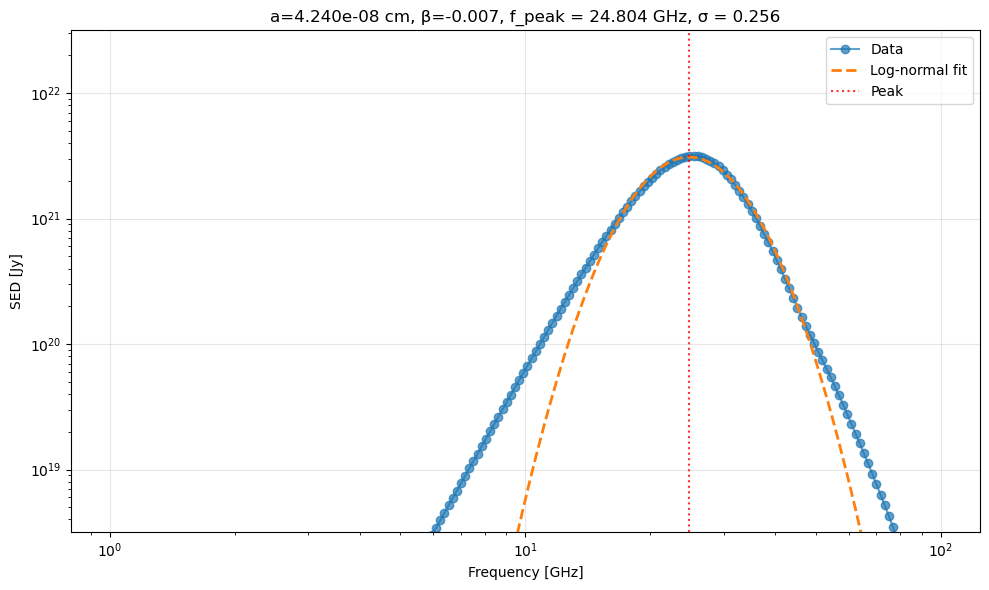

Fitting results:
Fitted peak frequency: 2.48e+01 ± 4.79e-02 Hz
Fitted sigma: 0.256 ± 0.002
FWHM: 1.52e+01 Hz
R-squared: 0.9951


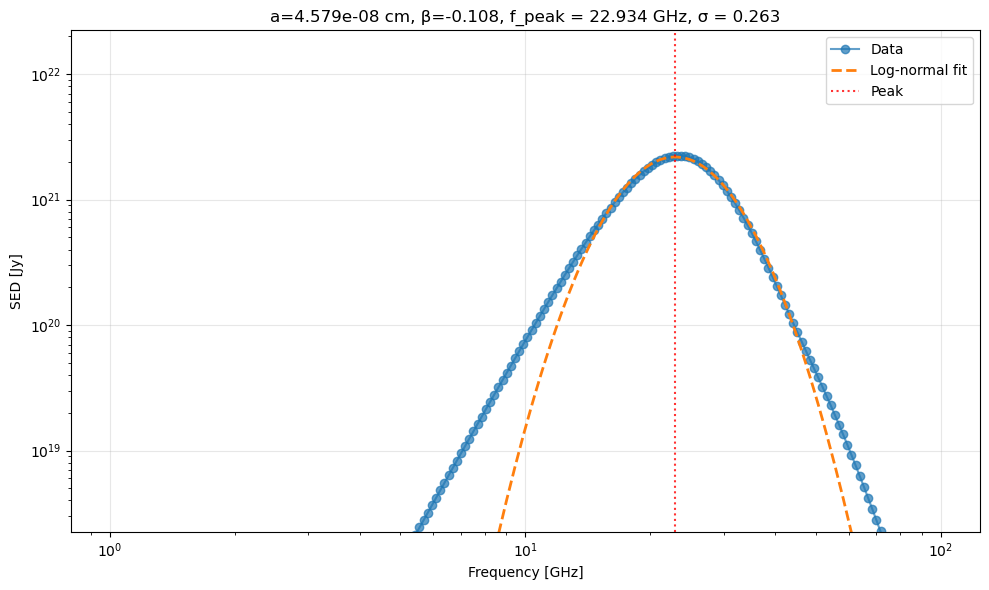

Fitting results:
Fitted peak frequency: 2.29e+01 ± 4.24e-02 Hz
Fitted sigma: 0.263 ± 0.002
FWHM: 1.44e+01 Hz
R-squared: 0.9957


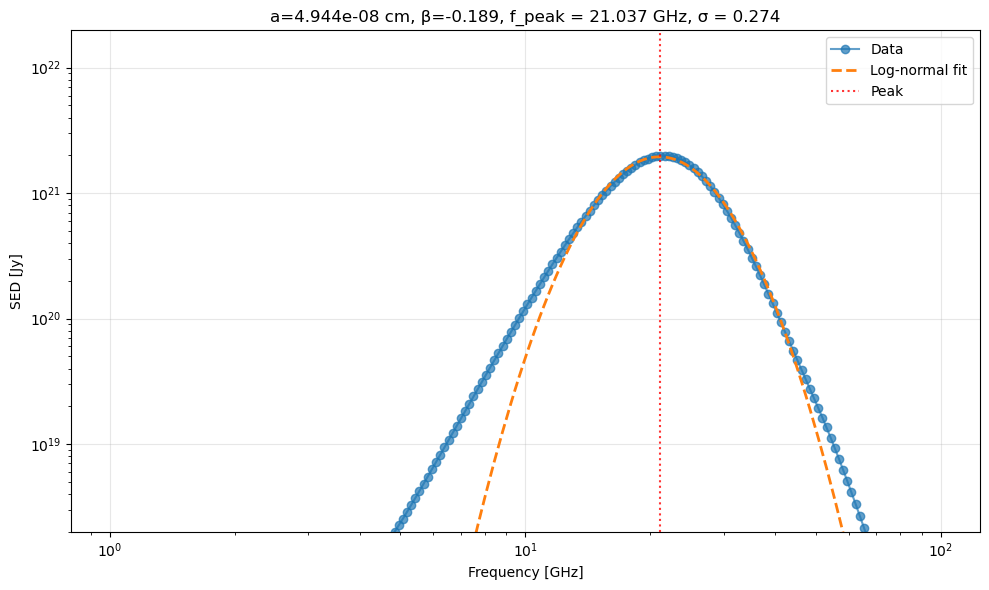

Fitting results:
Fitted peak frequency: 2.10e+01 ± 3.70e-02 Hz
Fitted sigma: 0.274 ± 0.002
FWHM: 1.38e+01 Hz
R-squared: 0.9963


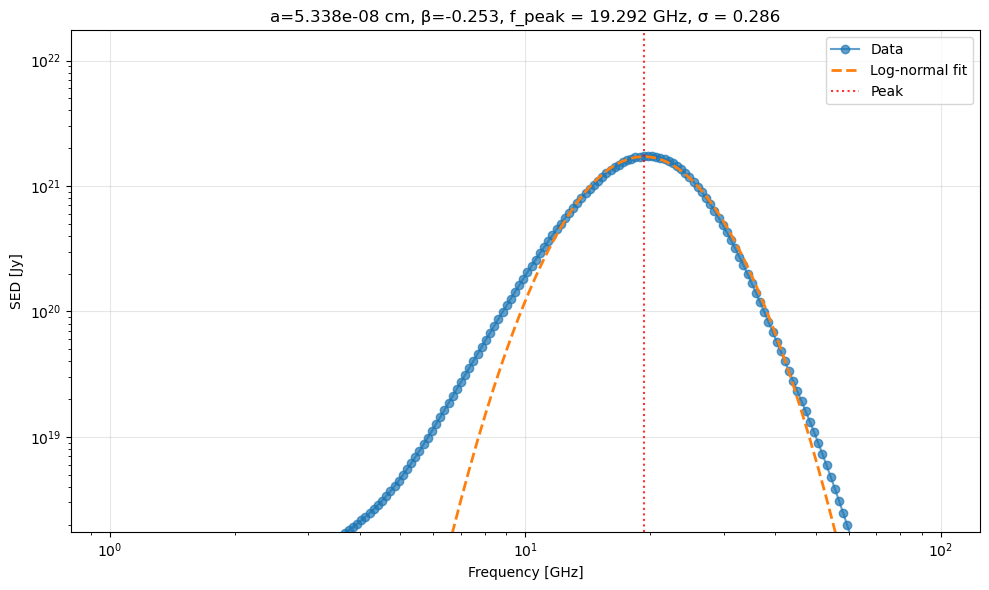

Fitting results:
Fitted peak frequency: 1.93e+01 ± 3.30e-02 Hz
Fitted sigma: 0.286 ± 0.002
FWHM: 1.32e+01 Hz
R-squared: 0.9966


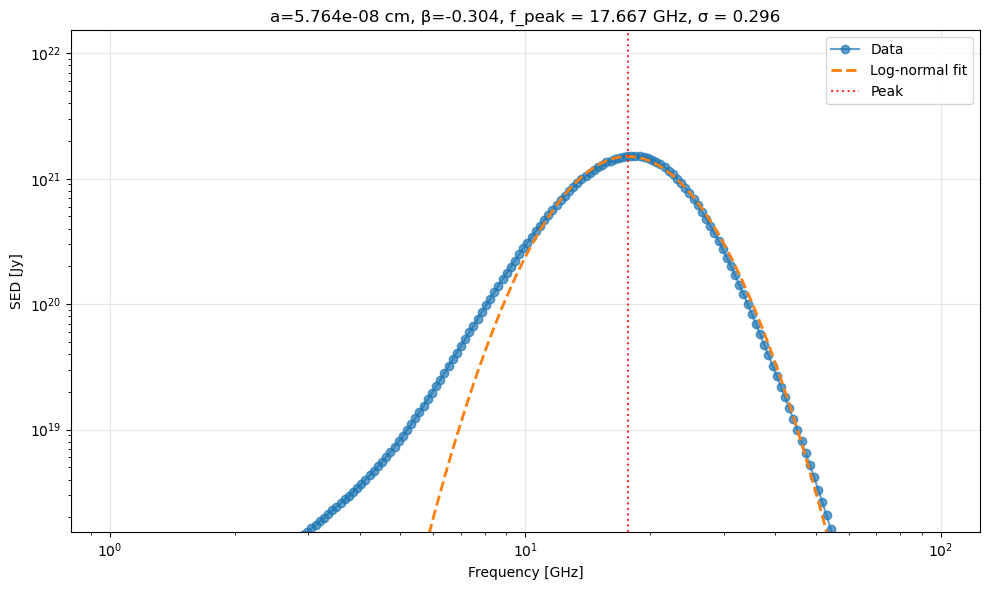

Fitting results:
Fitted peak frequency: 1.77e+01 ± 3.17e-02 Hz
Fitted sigma: 0.296 ± 0.002
FWHM: 1.26e+01 Hz
R-squared: 0.9964


In [21]:
peak_disk_2d = []
sigma_disk_2d = []

for (a, i) in zip(a_disk, range(len(a_disk))):
    beta = eval_beta_2d(a)
    pfreq, sigma = sizeSED_lognormal_fitting(a, beta, save_path=f'figures/discSED_2d_{i}.pdf')
    peak_disk_2d.append(pfreq)
    sigma_disk_2d.append(sigma)

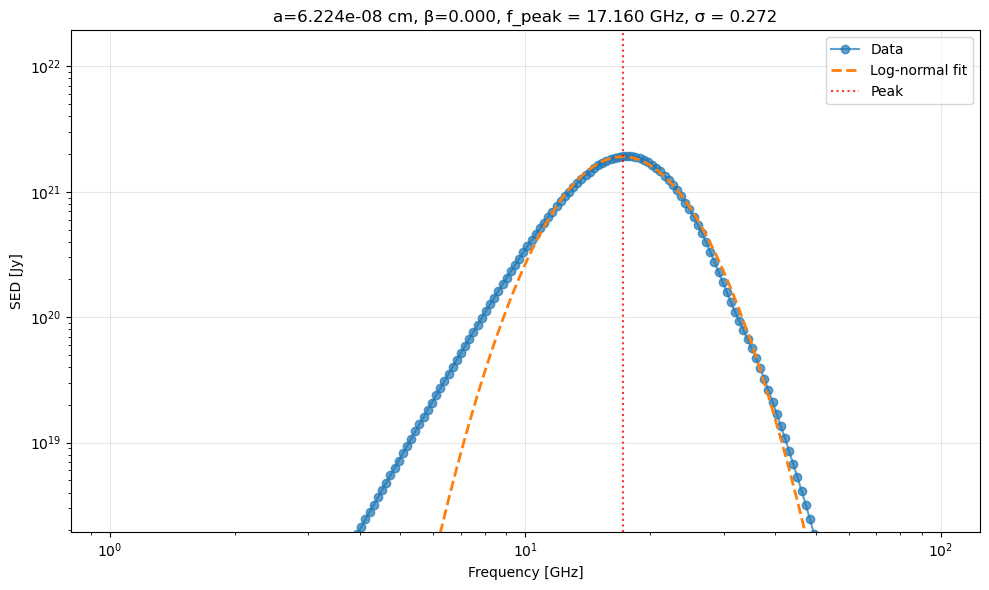

Fitting results:
Fitted peak frequency: 1.72e+01 ± 3.34e-02 Hz
Fitted sigma: 0.272 ± 0.002
FWHM: 1.12e+01 Hz
R-squared: 0.9955


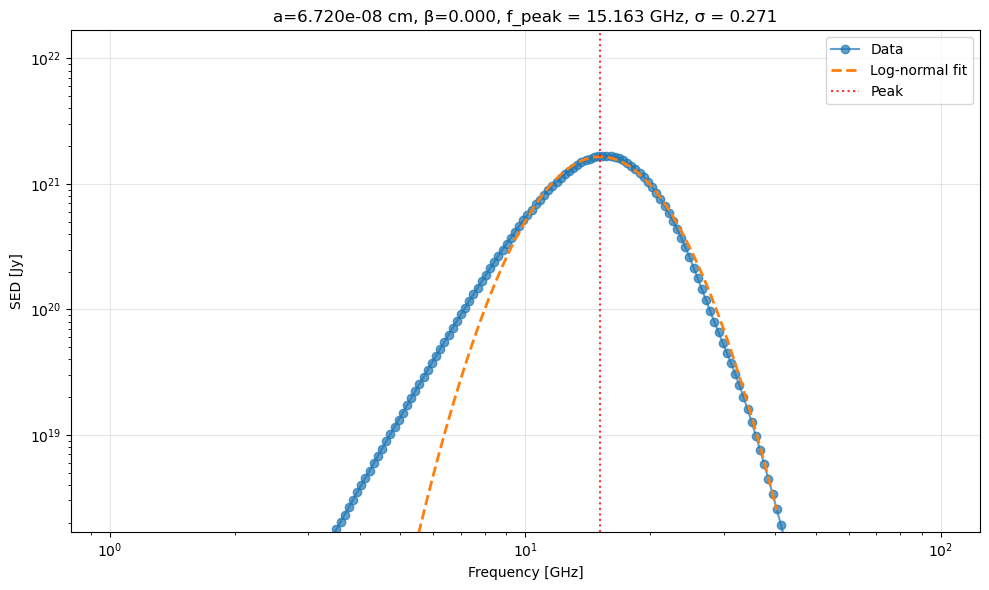

Fitting results:
Fitted peak frequency: 1.52e+01 ± 3.21e-02 Hz
Fitted sigma: 0.271 ± 0.002
FWHM: 9.85e+00 Hz
R-squared: 0.9947


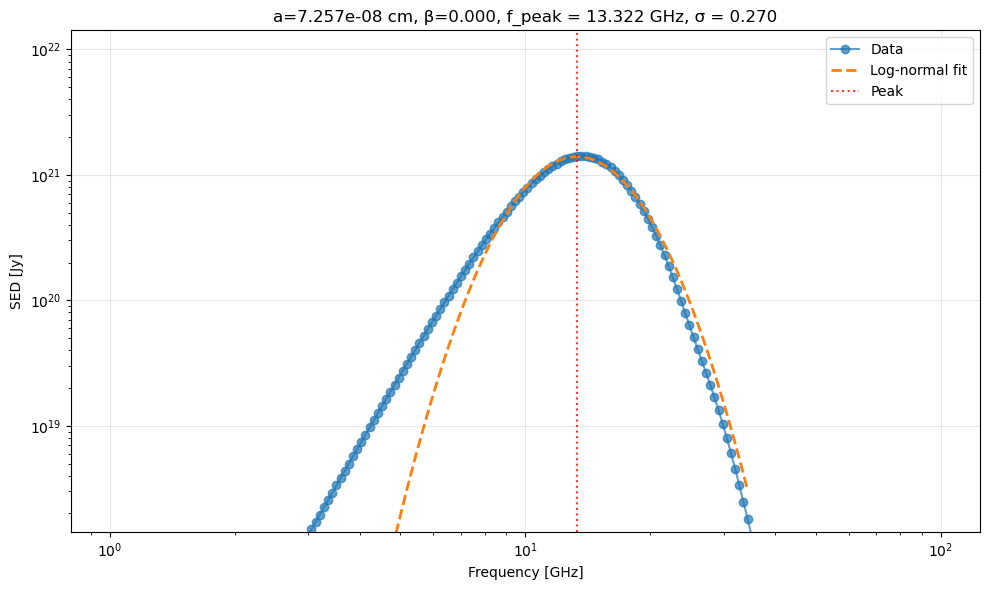

Fitting results:
Fitted peak frequency: 1.33e+01 ± 3.12e-02 Hz
Fitted sigma: 0.270 ± 0.002
FWHM: 8.62e+00 Hz
R-squared: 0.9935


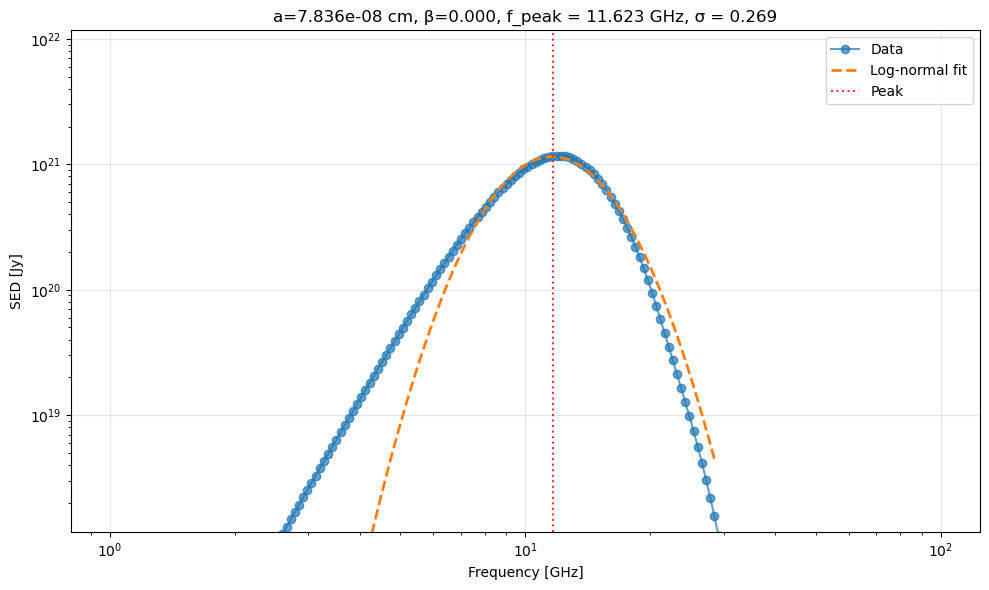

Fitting results:
Fitted peak frequency: 1.16e+01 ± 3.02e-02 Hz
Fitted sigma: 0.269 ± 0.003
FWHM: 7.49e+00 Hz
R-squared: 0.9920


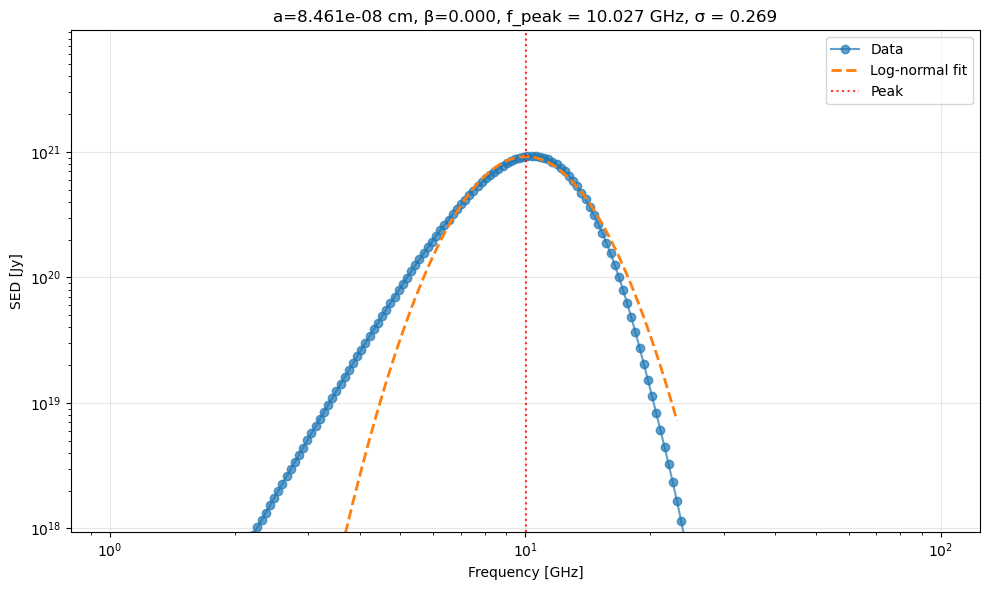

Fitting results:
Fitted peak frequency: 1.00e+01 ± 2.88e-02 Hz
Fitted sigma: 0.269 ± 0.003
FWHM: 6.46e+00 Hz
R-squared: 0.9903


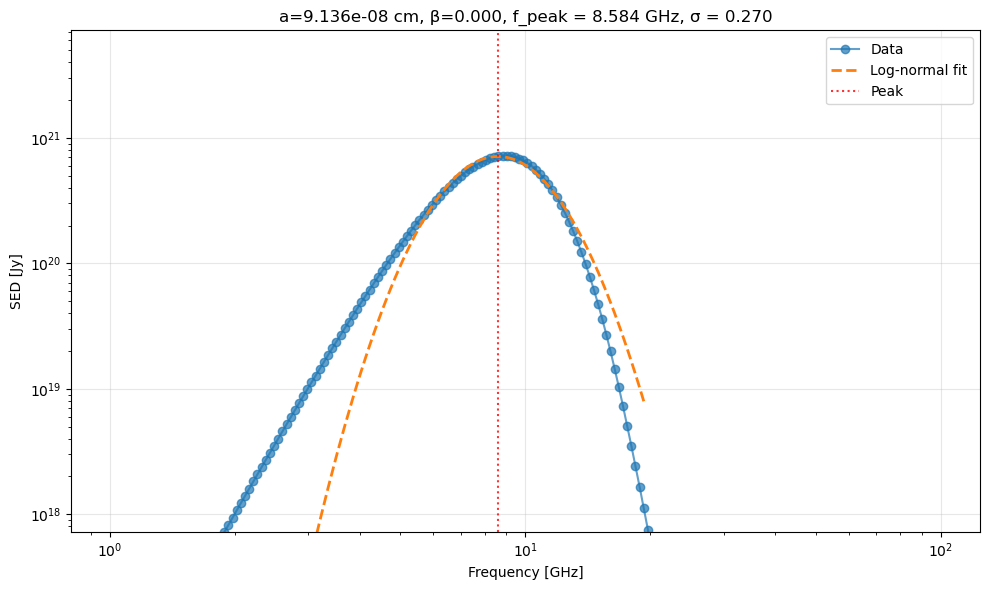

Fitting results:
Fitted peak frequency: 8.58e+00 ± 2.70e-02 Hz
Fitted sigma: 0.270 ± 0.003
FWHM: 5.55e+00 Hz
R-squared: 0.9885


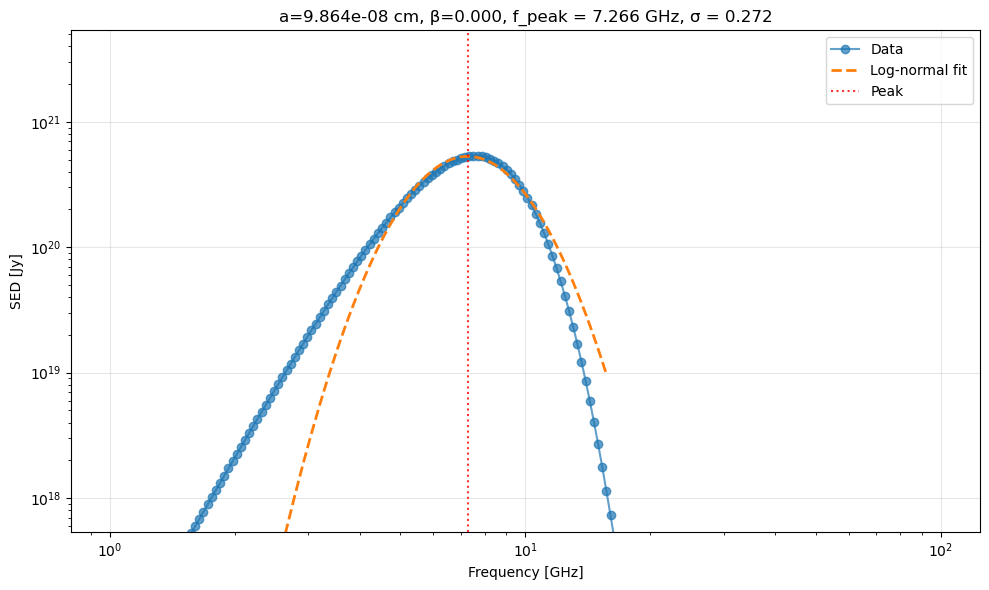

Fitting results:
Fitted peak frequency: 7.27e+00 ± 2.46e-02 Hz
Fitted sigma: 0.272 ± 0.003
FWHM: 4.73e+00 Hz
R-squared: 0.9869


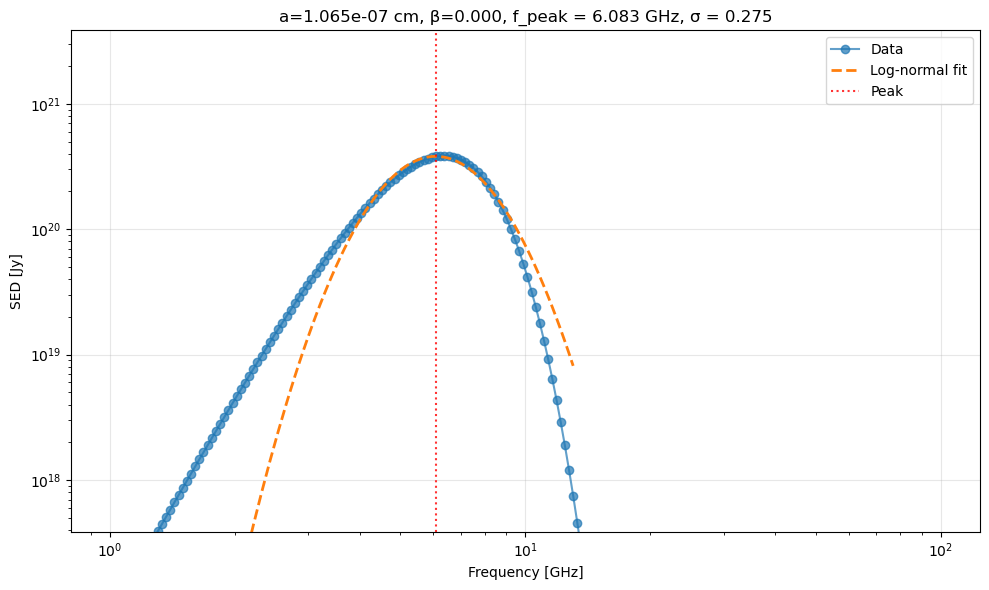

Fitting results:
Fitted peak frequency: 6.08e+00 ± 2.15e-02 Hz
Fitted sigma: 0.275 ± 0.004
FWHM: 4.00e+00 Hz
R-squared: 0.9858


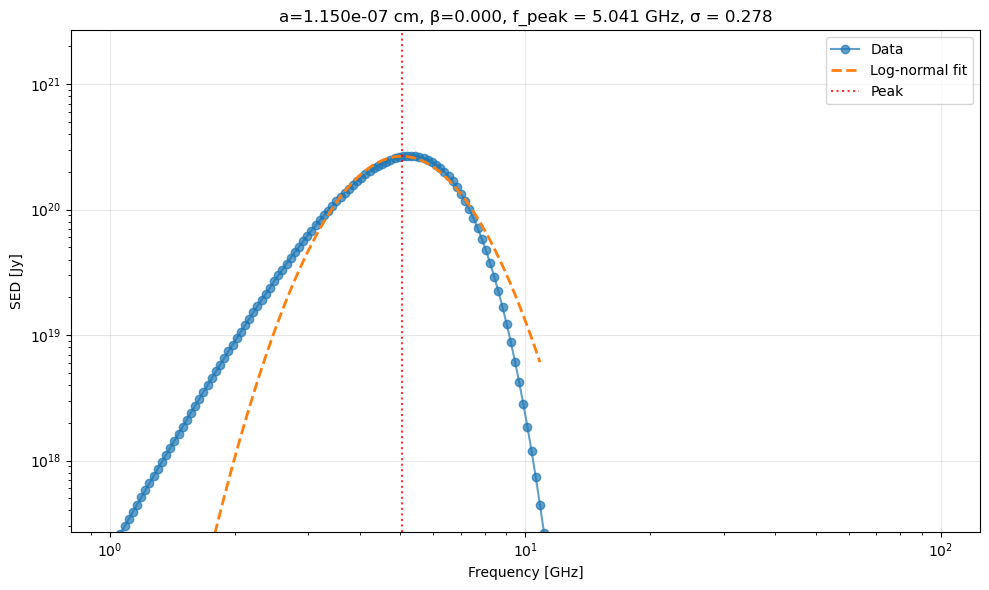

Fitting results:
Fitted peak frequency: 5.04e+00 ± 1.84e-02 Hz
Fitted sigma: 0.278 ± 0.004
FWHM: 3.37e+00 Hz
R-squared: 0.9852


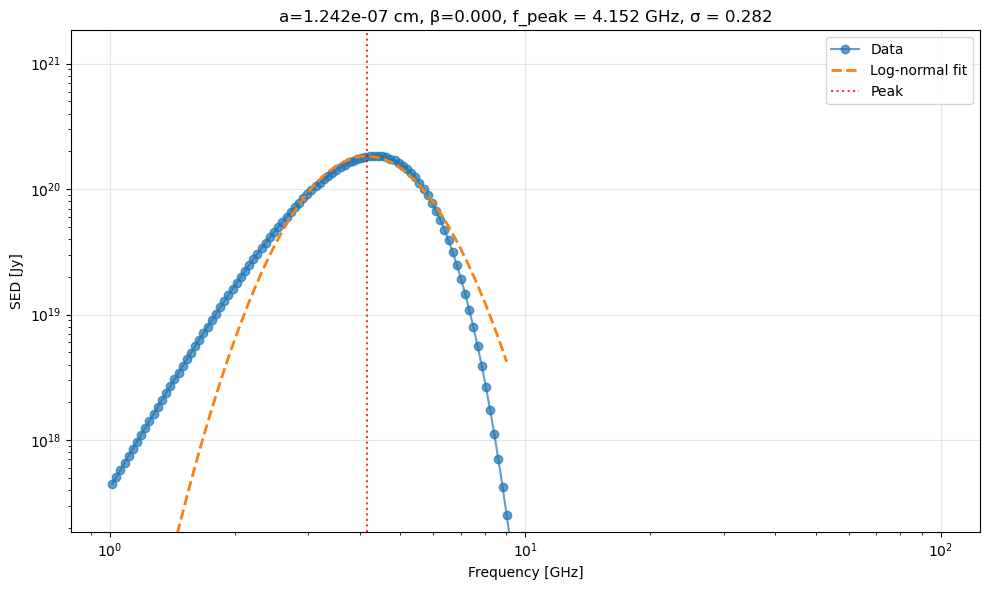

Fitting results:
Fitted peak frequency: 4.15e+00 ± 1.57e-02 Hz
Fitted sigma: 0.282 ± 0.004
FWHM: 2.81e+00 Hz
R-squared: 0.9846


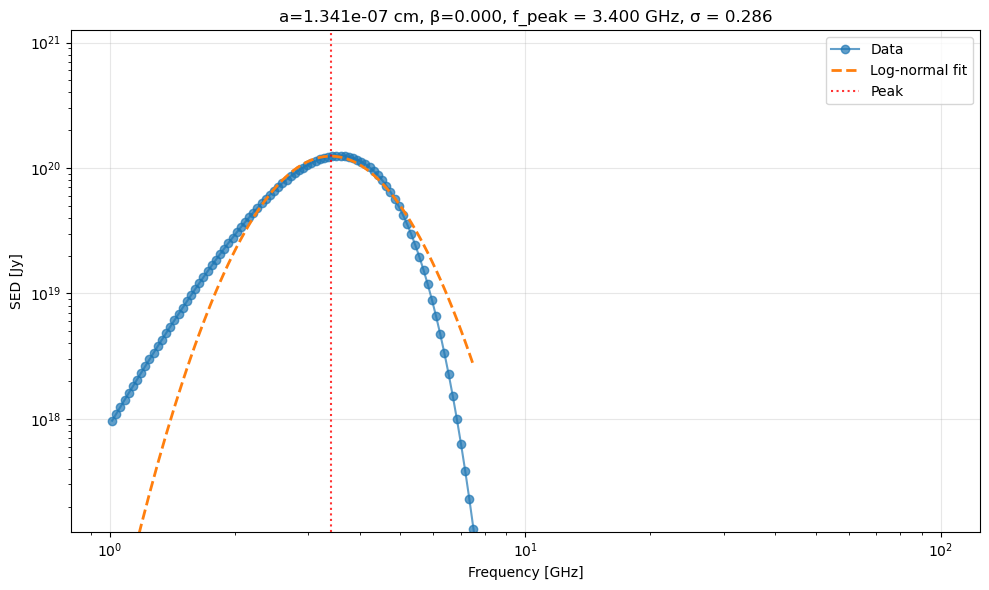

Fitting results:
Fitted peak frequency: 3.40e+00 ± 1.34e-02 Hz
Fitted sigma: 0.286 ± 0.004
FWHM: 2.33e+00 Hz
R-squared: 0.9836


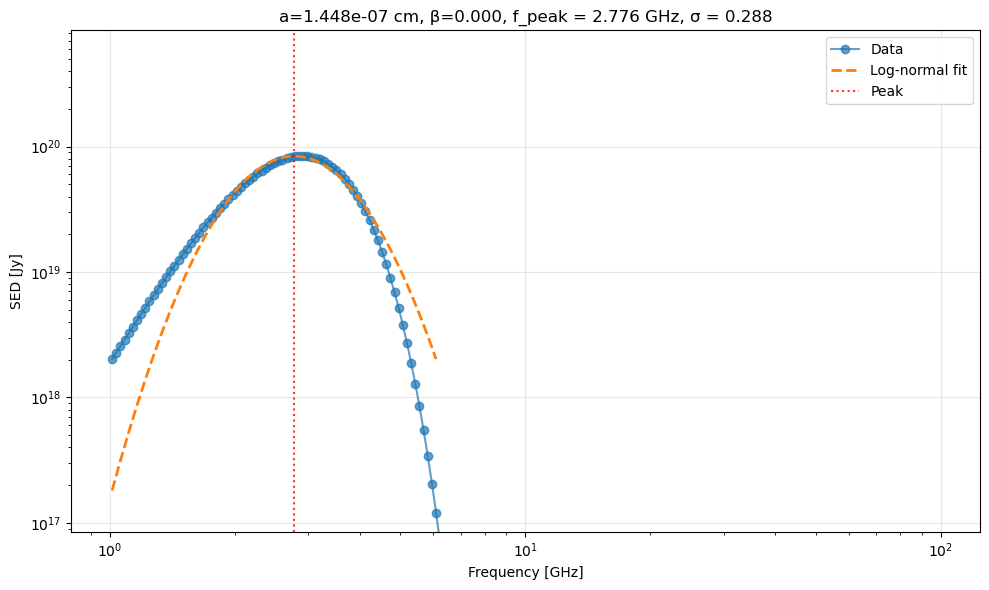

Fitting results:
Fitted peak frequency: 2.78e+00 ± 1.14e-02 Hz
Fitted sigma: 0.288 ± 0.004
FWHM: 1.92e+00 Hz
R-squared: 0.9823


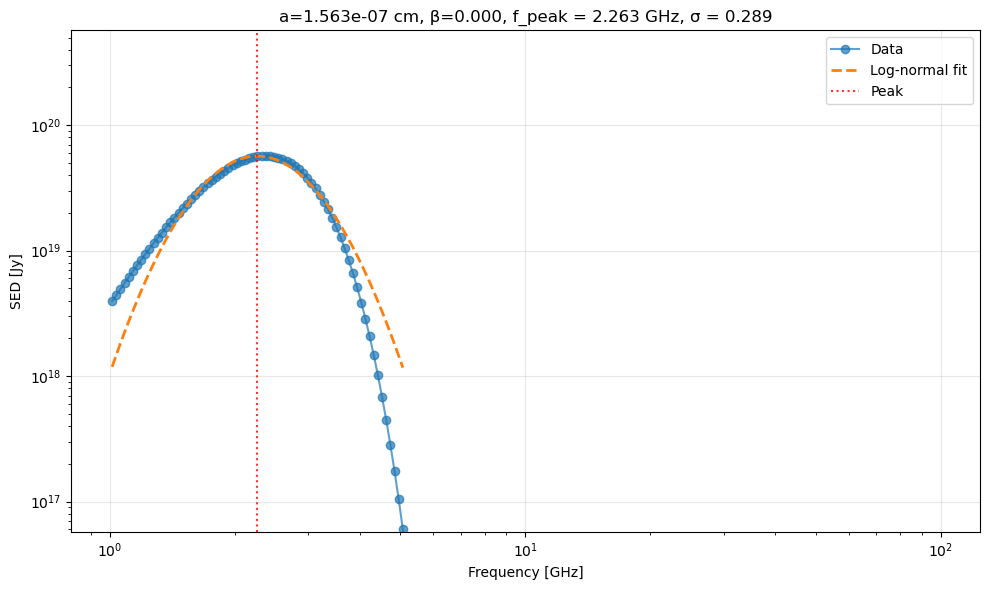

Fitting results:
Fitted peak frequency: 2.26e+00 ± 9.42e-03 Hz
Fitted sigma: 0.289 ± 0.004
FWHM: 1.57e+00 Hz
R-squared: 0.9816


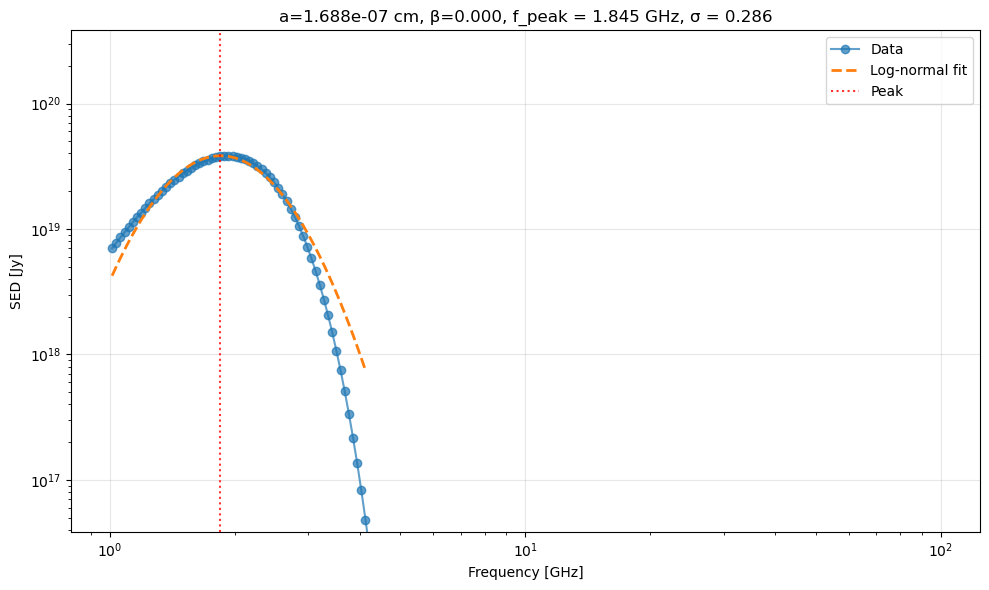

Fitting results:
Fitted peak frequency: 1.84e+00 ± 7.15e-03 Hz
Fitted sigma: 0.286 ± 0.004
FWHM: 1.27e+00 Hz
R-squared: 0.9838


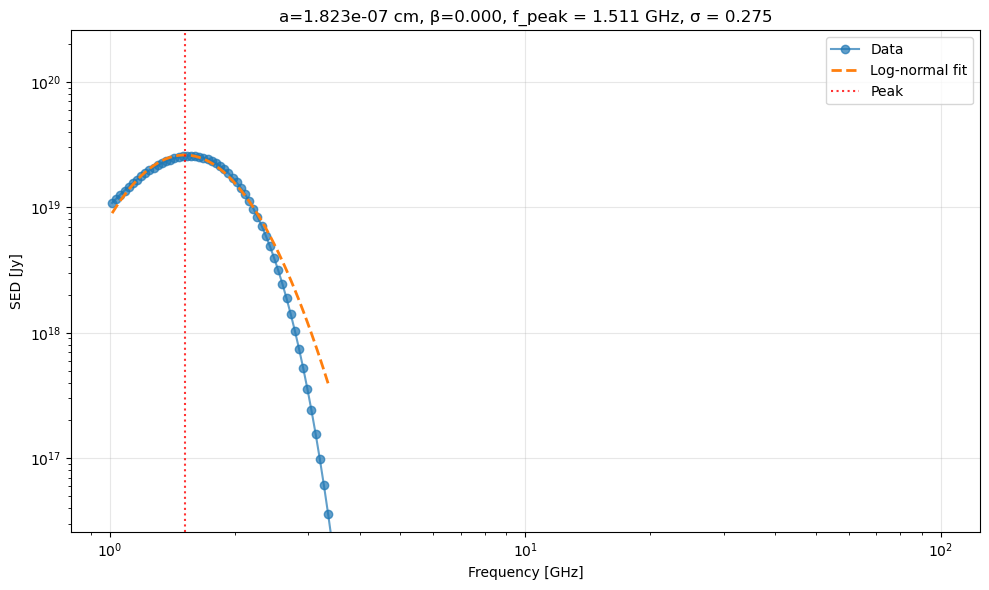

Fitting results:
Fitted peak frequency: 1.51e+00 ± 4.80e-03 Hz
Fitted sigma: 0.275 ± 0.004
FWHM: 9.95e-01 Hz
R-squared: 0.9907
Error in fitting: Need at least 3 valid data points for fitting. Only 0 points above threshold inf


/Users/zzhang/Workspace/SpyDust/SpyDust/SED.py:187: RuntimeWarning: overflow encountered in exp
  emiss_mode_1 = 8/9 *  np.exp(interp_op(np.log(omega_tab)))  * omega_tab**4
/Users/zzhang/Workspace/SpyDust/SpyDust/SED.py:187: RuntimeWarning: overflow encountered in multiply
  emiss_mode_1 = 8/9 *  np.exp(interp_op(np.log(omega_tab)))  * omega_tab**4


UnboundLocalError: cannot access local variable 'results' where it is not associated with a value

In [25]:
peak_sphere = []
sigma_sphere = []

for (a, i) in zip(a_sphere, range(len(a_sphere))):
    beta = eval_beta_d(a)
    pfreq, sigma = sizeSED_lognormal_fitting(a, beta, save_path=f'figures/sphSED_1d_{i}.pdf')
    peak_sphere.append(pfreq)
    sigma_sphere.append(sigma)

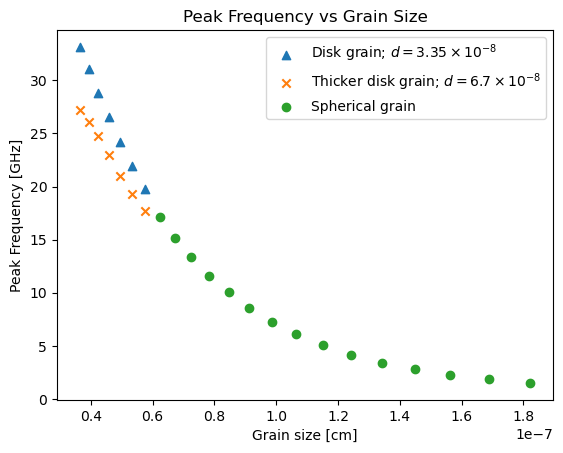

In [39]:
plt.scatter(a_disk, peak_disk_d, label=r'Disk grain; $d =3.35\times 10^{-8}$', marker='^')

plt.scatter(a_disk, peak_disk_2d, label=r'Thicker disk grain; $d =6.7\times 10^{-8}$', marker='x')

plt.scatter(a_sphere[:15], peak_sphere, label=r'Spherical grain')
plt.title('Peak Frequency vs Grain Size')

plt.ylabel('Peak Frequency [GHz]')
plt.xlabel('Grain size [cm]')
plt.legend()
plt.savefig('figures/peak_freq_vs_grain_size.pdf')

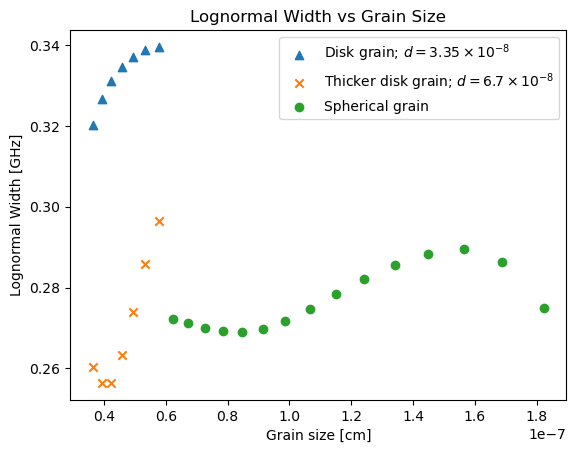

In [40]:
plt.scatter(a_disk, sigma_disk_d, label=r'Disk grain; $d =3.35\times 10^{-8}$', marker='^')

plt.scatter(a_disk, sigma_disk_2d, label=r'Thicker disk grain; $d =6.7\times 10^{-8}$', marker='x')

plt.scatter(a_sphere[:15], sigma_sphere, label=r'Spherical grain')

plt.ylabel('Lognormal Width [GHz]')
plt.xlabel('Grain size [cm]')
plt.title('Lognormal Width vs Grain Size')
plt.legend()
plt.savefig('lognormal_width_vs_grain_size.pdf', dpi=300)

In [33]:
from SpyDust.util import cgsconst
from SpyDust.AngMomDist import log_f_rot
from SpyDust.charge_dist import charge_dist


In [ ]:
def generate_SED_list(a_list, thick_2d=False):
    SED_list = []
    for a in a_list:
        if thick_2d:
            result = SpyDust_given_grain_size_shape(CNM_params, a, eval_beta_2d(a))
        else:
            result = SpyDust_given_grain_size_shape(CNM_params, a, eval_beta_d(a))
        SED_list.append(result)
    return SED_list

def generate_synth_SED(SED_list, a_list, a_dist, weighted=True):
    if not weighted:
        a_weighted_dist = np.array(a_dist) * grain_obj.Da_over_a * np.array(a_list)
        a_weighted_dist /= np.sum(a_weighted_dist)
    else:
        a_weighted_dist = np.array(a_dist)
    resultSED = np.sum(a_weighted_dist[:, np.newaxis] * np.array(SED_list), axis=0)
    return resultSED

# ---------- helpers -------------------------------------------------
def _normalise(w):
    """Turn any non–negative weight array into a PDF."""
    w = np.asarray(w, dtype=float)
    if np.any(w < 0):                       # sanity check
        raise ValueError("Weights must be non-negative.")
    s = w.sum()
    if s == 0:
        raise ValueError("All weights are zero → cannot normalise.")
    return w / s

# ---------- 1. Power-law over discrete points -----------------------
def power_law_pdf(x, gamma=1.0):
    """
    P(x_i) ∝ x_i^{gamma}.  
    """
    x = np.asarray(x)
    if np.any(x <= 0):
        raise ValueError("Power-law needs strictly positive x.")
    weights = x ** gamma
    return _normalise(weights)

def log_normal_pdf(x, mu=0.0, sigma=1.0):
    """
    P(x_i) ∝ exp(-((log(x_i) - mu) / sigma)^2 / 2).
    """
    x = np.asarray(x)
    if np.any(x <= 0):
        raise ValueError("Log-normal needs strictly positive x.")
    weights = np.exp(-((np.log(x) - mu) / sigma) ** 2 / 2)
    return _normalise(weights)


In [ ]:
# Install MomentEmu with all dependencies using the correct syntax
# %pip install "MomentEmu[all] @ git+https://github.com/MomentEmu/MomentEmu.git"

In [34]:
# ---------- helpers -------------------------------------------------
def _normalise(w):
    """Turn any non–negative weight array into a PDF."""
    w = np.asarray(w, dtype=float)
    if np.any(w < 0):                       # sanity check
        raise ValueError("Weights must be non-negative.")
    s = w.sum()
    if s == 0:
        raise ValueError("All weights are zero → cannot normalise.")
    return w / s

# ---------- 1. Power-law over discrete points -----------------------
def power_law_pdf(x, gamma=1.0):
    """
    P(x_i) ∝ x_i^{gamma}.  
    """
    x = np.asarray(x)
    if np.any(x <= 0):
        raise ValueError("Power-law needs strictly positive x.")
    weights = x ** gamma
    return _normalise(weights)

# ---------- 2. Peaked (Gaussian) ------------------------------------
def gaussian_pdf(x, mu=None, sigma=None):
    """
    Discrete Gaussian on your grid.
    By default, centre in the middle of the range and
    use σ = 0.2 · (x_max – x_min).
    """
    x = np.asarray(x, dtype=float)
    if mu   is None: mu   = 0.5*(x.min() + x.max())
    if sigma is None: sigma = 0.2*(x.max() - x.min())
    weights = np.exp(-0.5*((x - mu)/sigma)**2)
    return _normalise(weights)

# ---------- 3. WD01 ----------------------------------------------

from SpyDust.Grain import grain_distribution

WD01_model = grain_distribution()

def wd01_pdf(x, line=7):
    """
    WD01 distribution over the range of x.
    """
    x = np.asarray(x)
    dist_func = WD01_model.size_dist_func(line)
    # Apply the function element by element since it expects scalar inputs
    weights = np.array([dist_func(xi) for xi in x])
    return _normalise(weights)

In [ ]:
from SpyDust.util import homogeneous_dist
from SpyDust.full_Stokes import full_Stokes_SED

class spdust_conditional_SED:
    def __init__(self, obs_omegas, int_dist_func=homogeneous_dist, ext_dist_func=homogeneous_dist, impulse=None):
        self.obs_omegas = obs_omegas
        self.int_dist_func = int_dist_func
        self.ext_dist_func = ext_dist_func
        self.impulse = impulse

    @staticmethod
    def generate_loglog_rot_dist_func(env, a, beta, mu, ip):
        fZ = charge_dist(env, a, beta)
        mu_ip = np.array([mu * np.sqrt(ip)])
        mu_op = np.array([mu * np.sqrt(1 - ip)])
        
        # Define omega grid
        omega_min = 1e7
        omega_max = 3e13
        Nomega = 1000
        log_omega = np.linspace(np.log(omega_min), np.log(omega_max), Nomega)
        
        # Get rotation distribution
        log_f_a = log_f_rot(env, a, beta, fZ, mu_ip, mu_op, omega_min=omega_min, omega_max=omega_max, Nomega=Nomega)
        
        return log_omega, log_f_a[0, :]  # Take first mu value

    def generate(self, env, a, beta, mu, ip):
        self.log_omegas, self.log_rot_dist = self.generate_loglog_rot_dist_func(env, a, beta, mu, ip)
        spdust_model = full_Stokes_SED(rot_freq_grid=self.log_omegas, rot_dist_grid=self.log_rot_dist,
                                       log_freq=True, log_dist=True)
        result = spdust_model.generate_SED(self.obs_omegas, beta, ip, mu**2,
                                            internal_dist=self.int_dist_func, 
                                            impulse=self.impulse,
                                            external_dist=self.ext_dist_func, 
                                            max_workers=1, 
                                            full_Stokes=False)

        return result

In [13]:
obs_omegas_min = 2*np.pi*1e10
obs_omegas_max = 2*np.pi*5e10
obs_omegas_num = 500
obs_omegas = makelogtab(obs_omegas_min , obs_omegas_max , obs_omegas_num)

spd_model = spdust_conditional_SED(obs_omegas)

debye = cgsconst.debye
env = CNM_params
dip_per_at = env['dipole'] / np.sqrt(N_C(1e-7) + N_H(1e-7)) * debye


beta = beta_min

In [14]:
a_arr_disk = np.linspace(a_min, a2, 2000)

spd_SED_disk_list = []

for i, a in enumerate(a_arr_disk):
    beta = eval_beta(a) 
    fZ = charge_dist(CNM_params, a, beta)
    Z2 = np.sum(fZ[0, :]**2 * fZ[1, :])
    mu_rms = rms_dipole(a, beta, Z2, dip_per_at)
    spd_SED_a = spd_model.generate(CNM_params, a, beta, mu_rms, 2/3)
    spd_SED_disk_list.append(spd_SED_a)


samples_a_1 = a_arr_disk.reshape(-1, 1)  # Reshape to ensure it's a 2D array for plotting
samples_SED_1 = np.array(spd_SED_disk_list)


In [ ]:
# # If we use an emulator

# from MomentEmu import PolyEmu
# poly_spd_disk = PolyEmu(samples_a_1[:-1,:], samples_SED_1[:-1,:], forward=True, backward=False, max_degree_forward=50)

# # random draw netween a_min and a2
# a = np.random.uniform(a_min, a2)

# plt.loglog(obs_omegas,poly_spd_disk.forward_emulator(np.array([a]))[0], color='blue', label='PolyEmu SED Disk')
# # plot the log-emu
# # plt.loglog(obs_omegas, 10**(log10_poly_spd_disk.forward_emulator(np.array([4.01e-08]))[0]), color='blue', label='PolyEmu LogSED Disk')
# beta = eval_beta(a)
# fZ = charge_dist(CNM_params, a, beta)
# Z2 = np.sum(fZ[0, :]**2 * fZ[1, :])
# mu_rms = rms_dipole(a, beta, Z2, dip_per_at)
# spd_SED_a = spd_model.generate(CNM_params, a, beta, mu_rms, 2/3)
# plt.loglog(obs_omegas, spd_SED_a, linestyle='--', color='orange', label='SED Disk')
# plt.legend()
# plt.show()


In [15]:
def size_ensemble_power_law(index):
    a_list=a_arr_disk
    spd_SED = 0.
    a_pdf = power_law_pdf(a_list, gamma=index)
    # calculate the mean of a
    a_mean = np.sum(a_list * a_pdf) / np.sum(a_pdf)
    for i, a in enumerate(a_list):
        spd_SED += spd_SED_disk_list[i] * a_pdf[i]
    return spd_SED, a_mean


def size_ensemble_gaussian():
    a_list=a_arr_disk
    spd_SED = 0.
    a_pdf = gaussian_pdf(a_list, mu=0.5*(a_min + a_max), sigma=0.2*(a_max - a_min))
    # calculate the mean of a
    a_mean = np.sum(a_list * a_pdf) / np.sum(a_pdf)
    for i, a in enumerate(a_list):
        spd_SED += spd_SED_disk_list[i] * a_pdf[i]
    return spd_SED, a_mean

def size_ensemble_wd01(line):
    a_list=a_arr_disk
    spd_SED = 0.
    a_pdf = wd01_pdf(a_list, line=line)
    # calculate the mean of a
    a_mean = np.sum(a_list * a_pdf) / np.sum(a_pdf)
    for i, a in enumerate(a_list):
        # fZ = charge_dist(CNM_params, a, beta)
        # Z2 = np.sum(fZ[0, :]**2 * fZ[1, :])
        # mu_rms = rms_dipole(a, beta, Z2, dip_per_at)
        # spd_SED += spd_model.generate(CNM_params, a, beta, mu_rms, 2/3) * a_pdf[i]
        spd_SED += spd_SED_disk_list[i] * a_pdf[i]
    return spd_SED, a_mean

In [69]:
a_arr_disk

array([3.63692806e-08, 3.63811019e-08, 3.63929232e-08, ...,
       5.99763575e-08, 5.99881787e-08, 6.00000000e-08], shape=(2000,))

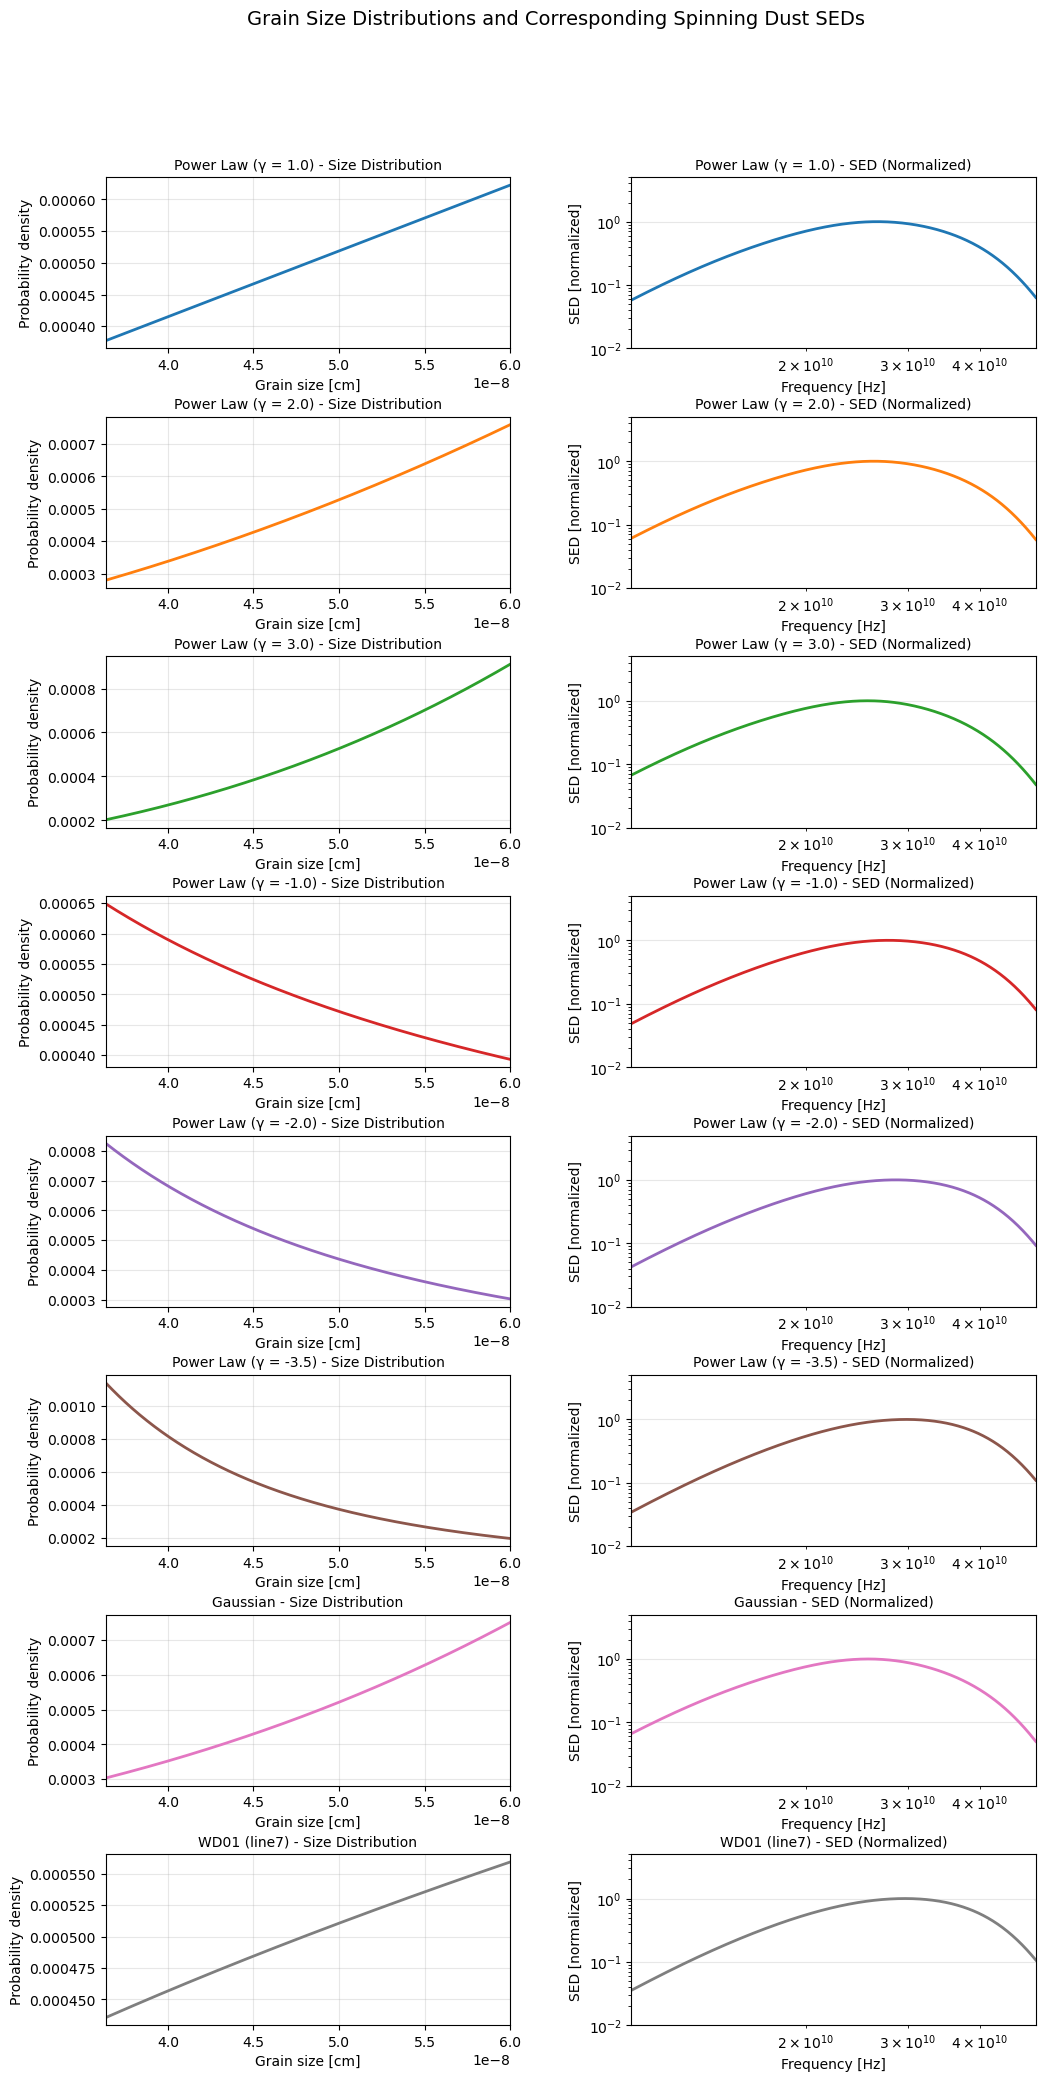

In [ ]:

SED_pl_1, pivot_1 = size_ensemble_power_law(0.5)
SED_pl_2, pivot_2 = size_ensemble_power_law(1.0)
SED_pl_3, pivot_3 = size_ensemble_power_law(2.0)
SED_pl_m1, pivot_m1 = size_ensemble_power_law(-1.0)
SED_pl_m2, pivot_m2 = size_ensemble_power_law(-2.0)
SED_pl_m3, pivot_m3 = size_ensemble_power_law(-3.5)
SED_gaus, pivot_gaus = size_ensemble_gaussian()
SED_wd01, pivot_wd01 = size_ensemble_wd01(6)

# Create comprehensive figure with 2 columns, 8 rows
fig, axes = plt.subplots(8, 2, figsize=(12, 24))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

a_list = a_arr_disk

# Define the distributions and their labels (replacing WD01 with a substitute)
distributions = [
    (power_law_pdf(a_list, gamma=0.5), SED_pl_1, 'Power Law (γ = 0.5)'),
    (power_law_pdf(a_list, gamma=1.0), SED_pl_2, 'Power Law (γ = 1.0)'),
    (power_law_pdf(a_list, gamma=2.0), SED_pl_3, 'Power Law (γ = 2.0)'),
    (power_law_pdf(a_list, gamma=-1.0), SED_pl_m1, 'Power Law (γ = -1.0)'),
    (power_law_pdf(a_list, gamma=-2.0), SED_pl_m2, 'Power Law (γ = -2.0)'),
    (power_law_pdf(a_list, gamma=-3.5), SED_pl_m3, 'Power Law (γ = -3.5)'),
    (gaussian_pdf(a_list, mu=0.5*(a_min + a_max), sigma=0.2*(a_max - a_min)), SED_gaus, 'Gaussian'),
    (wd01_pdf(a_list, line=6), SED_wd01, 'WD01 (line7)')  # Substitute for WD01
]

# Colors for consistency
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

# Plot each distribution and its corresponding SED
for i, (size_dist, sed, label) in enumerate(distributions):
    color = colors[i]
    
    # Left column: Size distribution
    axes[i, 0].plot(a_list, size_dist, color=color, linewidth=2)
    axes[i, 0].set_title(f'{label} - Size Distribution', fontsize=10)
    axes[i, 0].set_xlabel('Grain size [cm]')
    axes[i, 0].set_ylabel('Probability density')
    axes[i, 0].grid(True, alpha=0.3)
    axes[i, 0].set_xlim(a_min, a2)
    
    # Right column: SED (normalized)
    freq_hz = obs_omegas / (2 * np.pi)
    sed_normalized = sed / np.max(sed)  # Normalize to peak value
    axes[i, 1].loglog(freq_hz, sed_normalized, color=color, linewidth=2)
    axes[i, 1].set_title(f'{label} - SED (Normalized)', fontsize=10)
    axes[i, 1].set_xlabel('Frequency [Hz]')
    axes[i, 1].set_ylabel('SED [normalized]')
    axes[i, 1].grid(True, alpha=0.3)
    axes[i, 1].set_xlim(freq_hz.min(), freq_hz.max())
    axes[i, 1].set_ylim(1e-2, 5)  # 15 orders of magnitude from 1e-15 to 1

plt.suptitle('Grain Size Distributions and Corresponding Spinning Dust SEDs', fontsize=14, y=0.95)
plt.savefig('size_ensemble.png', dpi=300, bbox_inches='tight')
plt.show()

In [56]:
def CNM_cond_SED(a):
    beta = eval_beta(a) 
    fZ = charge_dist(CNM_params, a, beta)
    Z2 = np.sum(fZ[0, :]**2 * fZ[1, :])
    mu_rms = rms_dipole(a, beta, Z2, dip_per_at)
    return spd_model.generate(CNM_params, a, beta, mu_rms, 2/3)

def CNM_cond_1st_d_SED(a):
    result = ( CNM_cond_SED(1.05 * a) - CNM_cond_SED(0.95 * a) ) / (0.1 * a)
    return result

def CNM_cond_2nd_d_SED(a):
    result = ( CNM_cond_1st_d_SED(1.05 * a) - CNM_cond_1st_d_SED(0.95 * a) ) / (0.1 * a)
    return result

def CNM_cond_3rd_d_SED(a):
    result = ( CNM_cond_2nd_d_SED(1.05 * a) - CNM_cond_2nd_d_SED(0.95 * a) ) / (0.1 * a)
    return result

def CNM_cond_4th_d_SED(a):
    result = ( CNM_cond_3rd_d_SED(1.05 * a) - CNM_cond_3rd_d_SED(0.95 * a) ) / (0.1 * a)
    return result

def generate_deri_SEDs(a, normalise=False, max_order=3, remove_1st=False):
    # Calculate the zeroth, first, second, and third derivatives of the SED
    SED_0 = CNM_cond_SED(a)
    
    if max_order == 0:
        if normalise:
            SED_0 = SED_0 / np.max(SED_0)
        return SED_0
    elif max_order == 1:
        SED_1 = CNM_cond_1st_d_SED(a)
        derivatives = [SED_0, SED_1]
    elif max_order == 2:
        SED_1 = CNM_cond_1st_d_SED(a)
        SED_2 = CNM_cond_2nd_d_SED(a)
        derivatives = [SED_0, SED_1, SED_2]
    elif max_order == 3:
        SED_1 = CNM_cond_1st_d_SED(a)
        SED_2 = CNM_cond_2nd_d_SED(a)
        SED_3 = CNM_cond_3rd_d_SED(a)
        derivatives = [SED_0, SED_1, SED_2, SED_3]
    elif max_order == 4:
        SED_1 = CNM_cond_1st_d_SED(a)
        SED_2 = CNM_cond_2nd_d_SED(a)
        SED_3 = CNM_cond_3rd_d_SED(a)
        SED_4 = CNM_cond_4th_d_SED(a)
        derivatives = [SED_0, SED_1, SED_2, SED_3, SED_4]
    else:
        raise ValueError(f"max_order must be 0, 1, 2, 3, or 4, got {max_order}")

    # Apply normalization if requested
    if normalise:
        derivatives = [deriv / np.max(np.abs(deriv)) for deriv in derivatives]
    
    if remove_1st:
        # Remove the first derivative if requested
        derivatives = [deriv for i, deriv in enumerate(derivatives) if i != 1]

    # render them as a coefficient matrix of the linear system to solve
    # For lstsq(A, b), A should have shape (N_observations, N_parameters)
    # So we need to transpose: shape (N, max_order+1) where N = number of frequencies
    coeff_matrix = np.array(derivatives).T  # shape (N, max_order+1)
    return coeff_matrix

def linear_fit(a, target_SED, normalise=False, max_order=3, vanishing_1st_moment=False):
    coeff_matrix = generate_deri_SEDs(a, normalise=normalise, max_order=max_order, remove_1st=vanishing_1st_moment)
    # Solve the linear system: coeff_matrix @ params = target_SED
    # where params = [c0, c1, c2, c3] are the coefficients for the Taylor expansion
    fitted_params = np.linalg.lstsq(coeff_matrix, target_SED, rcond=None)[0]
    fitted_SED = coeff_matrix @ fitted_params
    residuals = target_SED - fitted_SED
    return fitted_params, fitted_SED, residuals

def linear_fit_given_basis(coeff_matrix, target_SED):
    fitted_params = np.linalg.lstsq(coeff_matrix, target_SED, rcond=None)[0]
    fitted_SED = coeff_matrix @ fitted_params
    residuals = target_SED - fitted_SED
    return fitted_params, fitted_SED, residuals


In [47]:
SEDs_to_fit = [SED_pl_1,
                SED_pl_2,   
                SED_pl_3,
                SED_pl_m1,
                SED_pl_m2,
                SED_pl_m3,
                SED_gaus,
                SED_wd01]

pivots_of_fit = [pivot_1, pivot_2, pivot_3, pivot_m1, pivot_m2, pivot_m3, pivot_gaus, pivot_wd01]

## Fit at pivot

In [50]:
SEDs_fitted_at_pivot = []
residuals_at_pivot = []

vanishing_1st_moment = True

for pivot, target_SED in zip(pivots_of_fit, SEDs_to_fit):
    fitted_params, fitted_SED, residuals = linear_fit(pivot, target_SED, normalise=True, max_order=3, vanishing_1st_moment=vanishing_1st_moment)
    SEDs_fitted_at_pivot.append(fitted_SED)
    residuals_at_pivot.append(residuals)

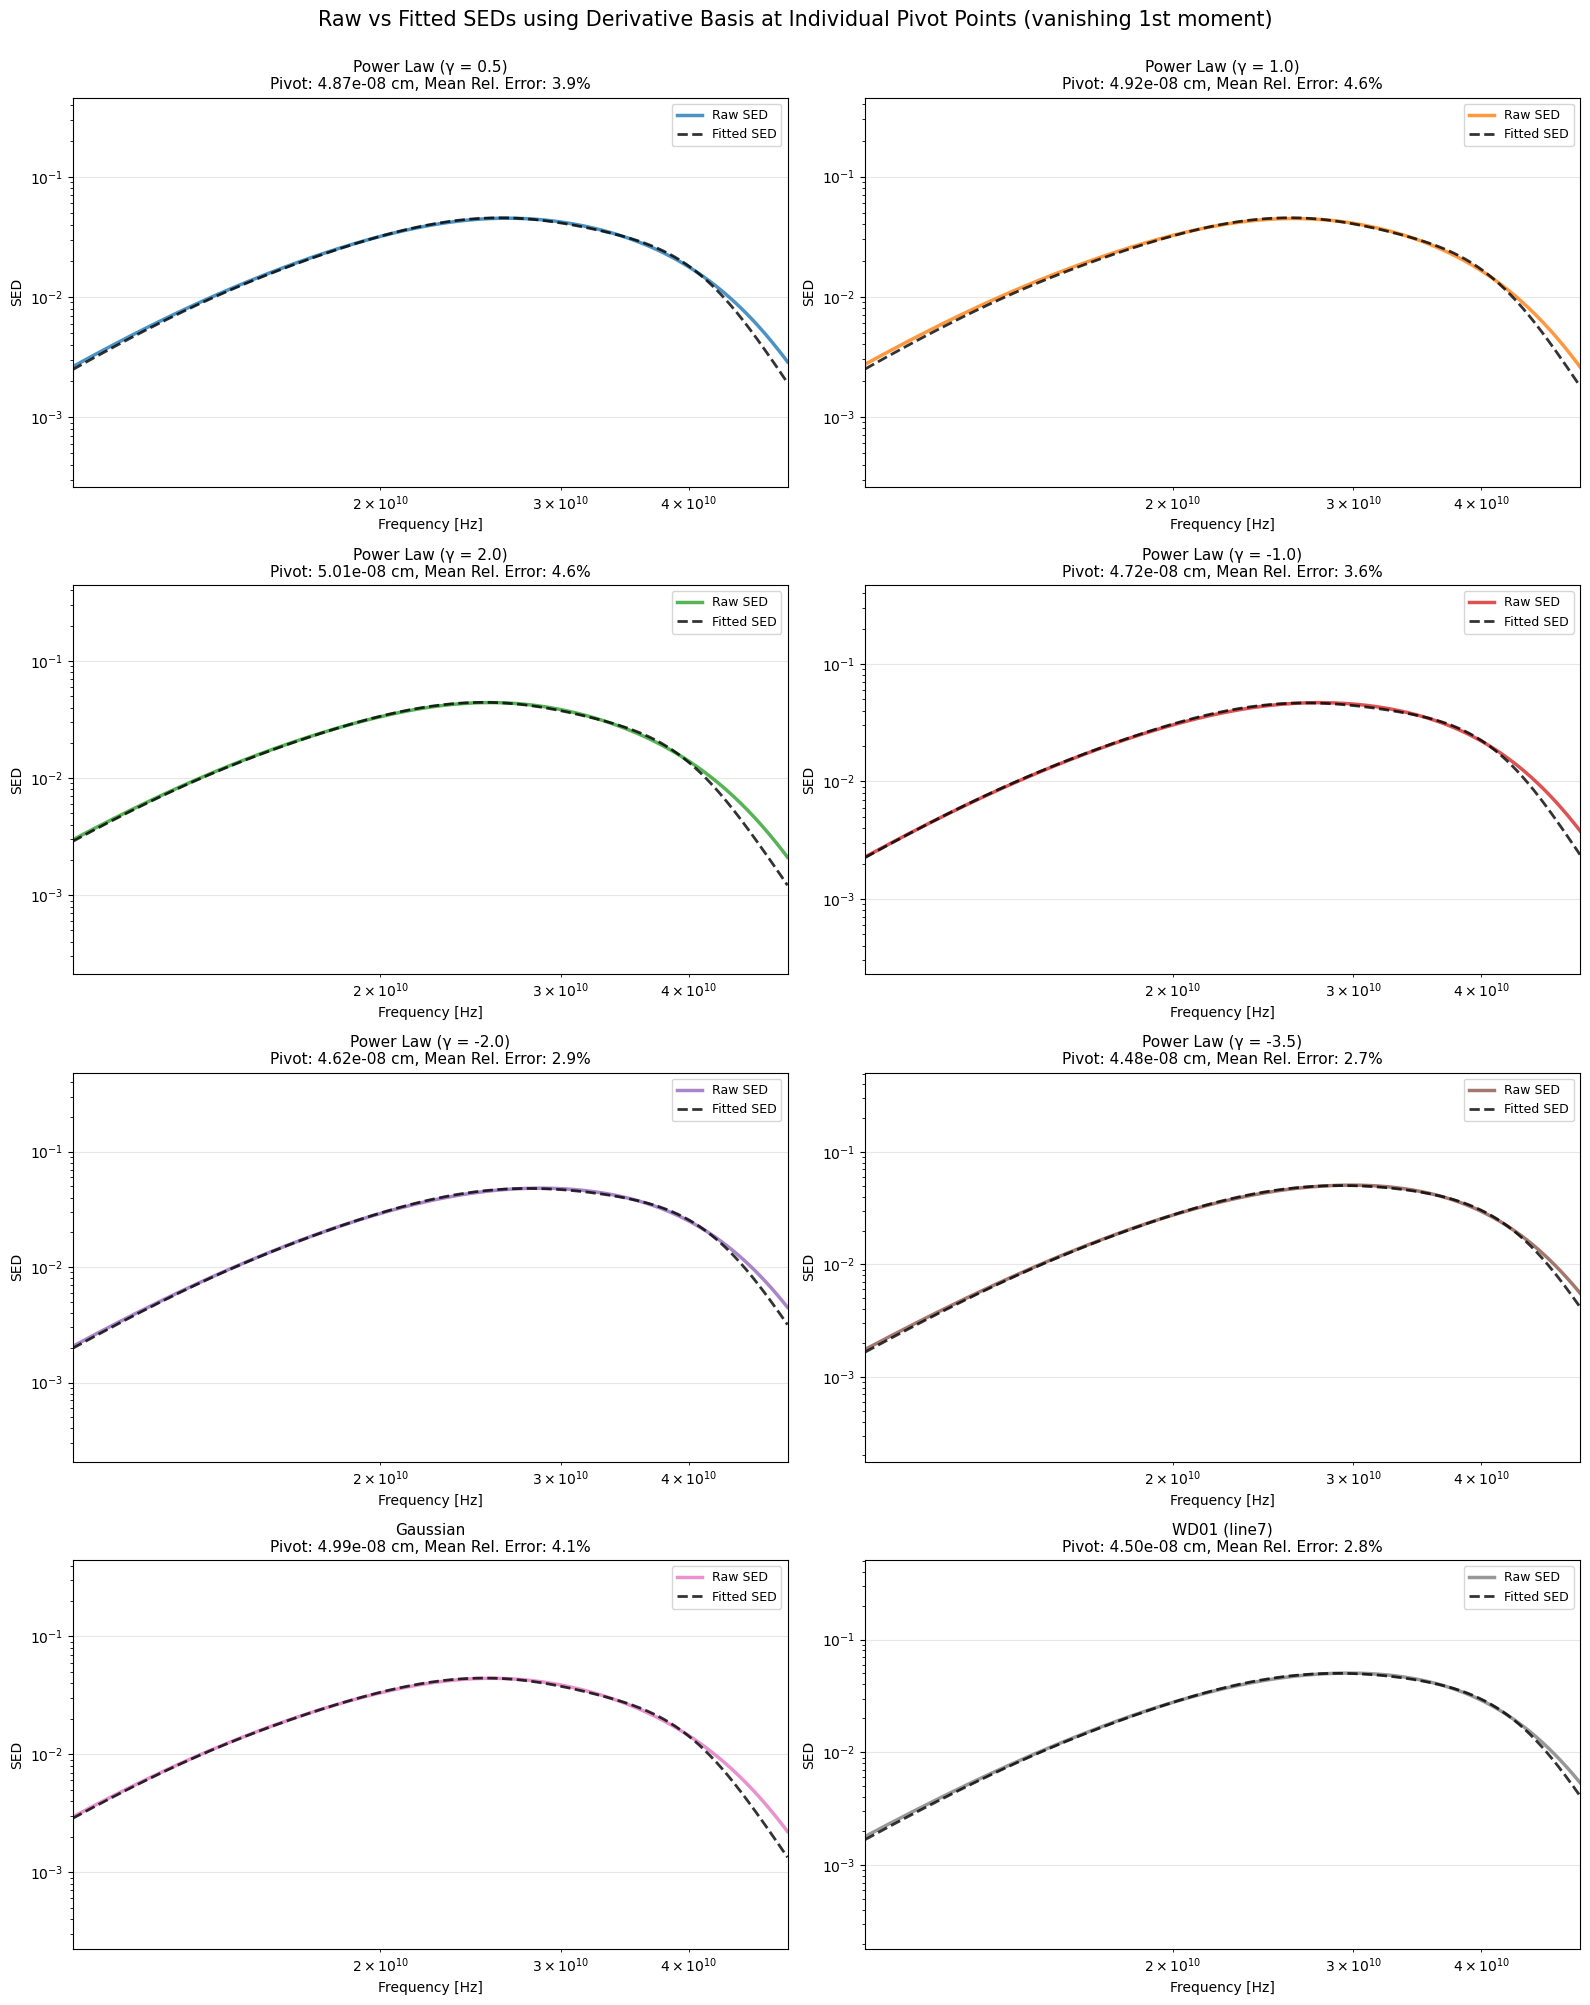


FITTING SUMMARY AT INDIVIDUAL PIVOT POINTS (with vanishing 1st moment)
SED Type                  Pivot [cm]      Mean Rel Error  RMS Residual   
--------------------------------------------------------------------------------
Power Law (γ = 0.5)       4.87e-08        3.9%            5.64e-04       
Power Law (γ = 1.0)       4.92e-08        4.6%            5.67e-04       
Power Law (γ = 2.0)       5.01e-08        4.6%            6.12e-04       
Power Law (γ = -1.0)      4.72e-08        3.6%            8.07e-04       
Power Law (γ = -2.0)      4.62e-08        2.9%            6.45e-04       
Power Law (γ = -3.5)      4.48e-08        2.7%            5.81e-04       
Gaussian                  4.99e-08        4.1%            5.91e-04       
WD01 (line7)              4.50e-08        2.8%            5.64e-04       


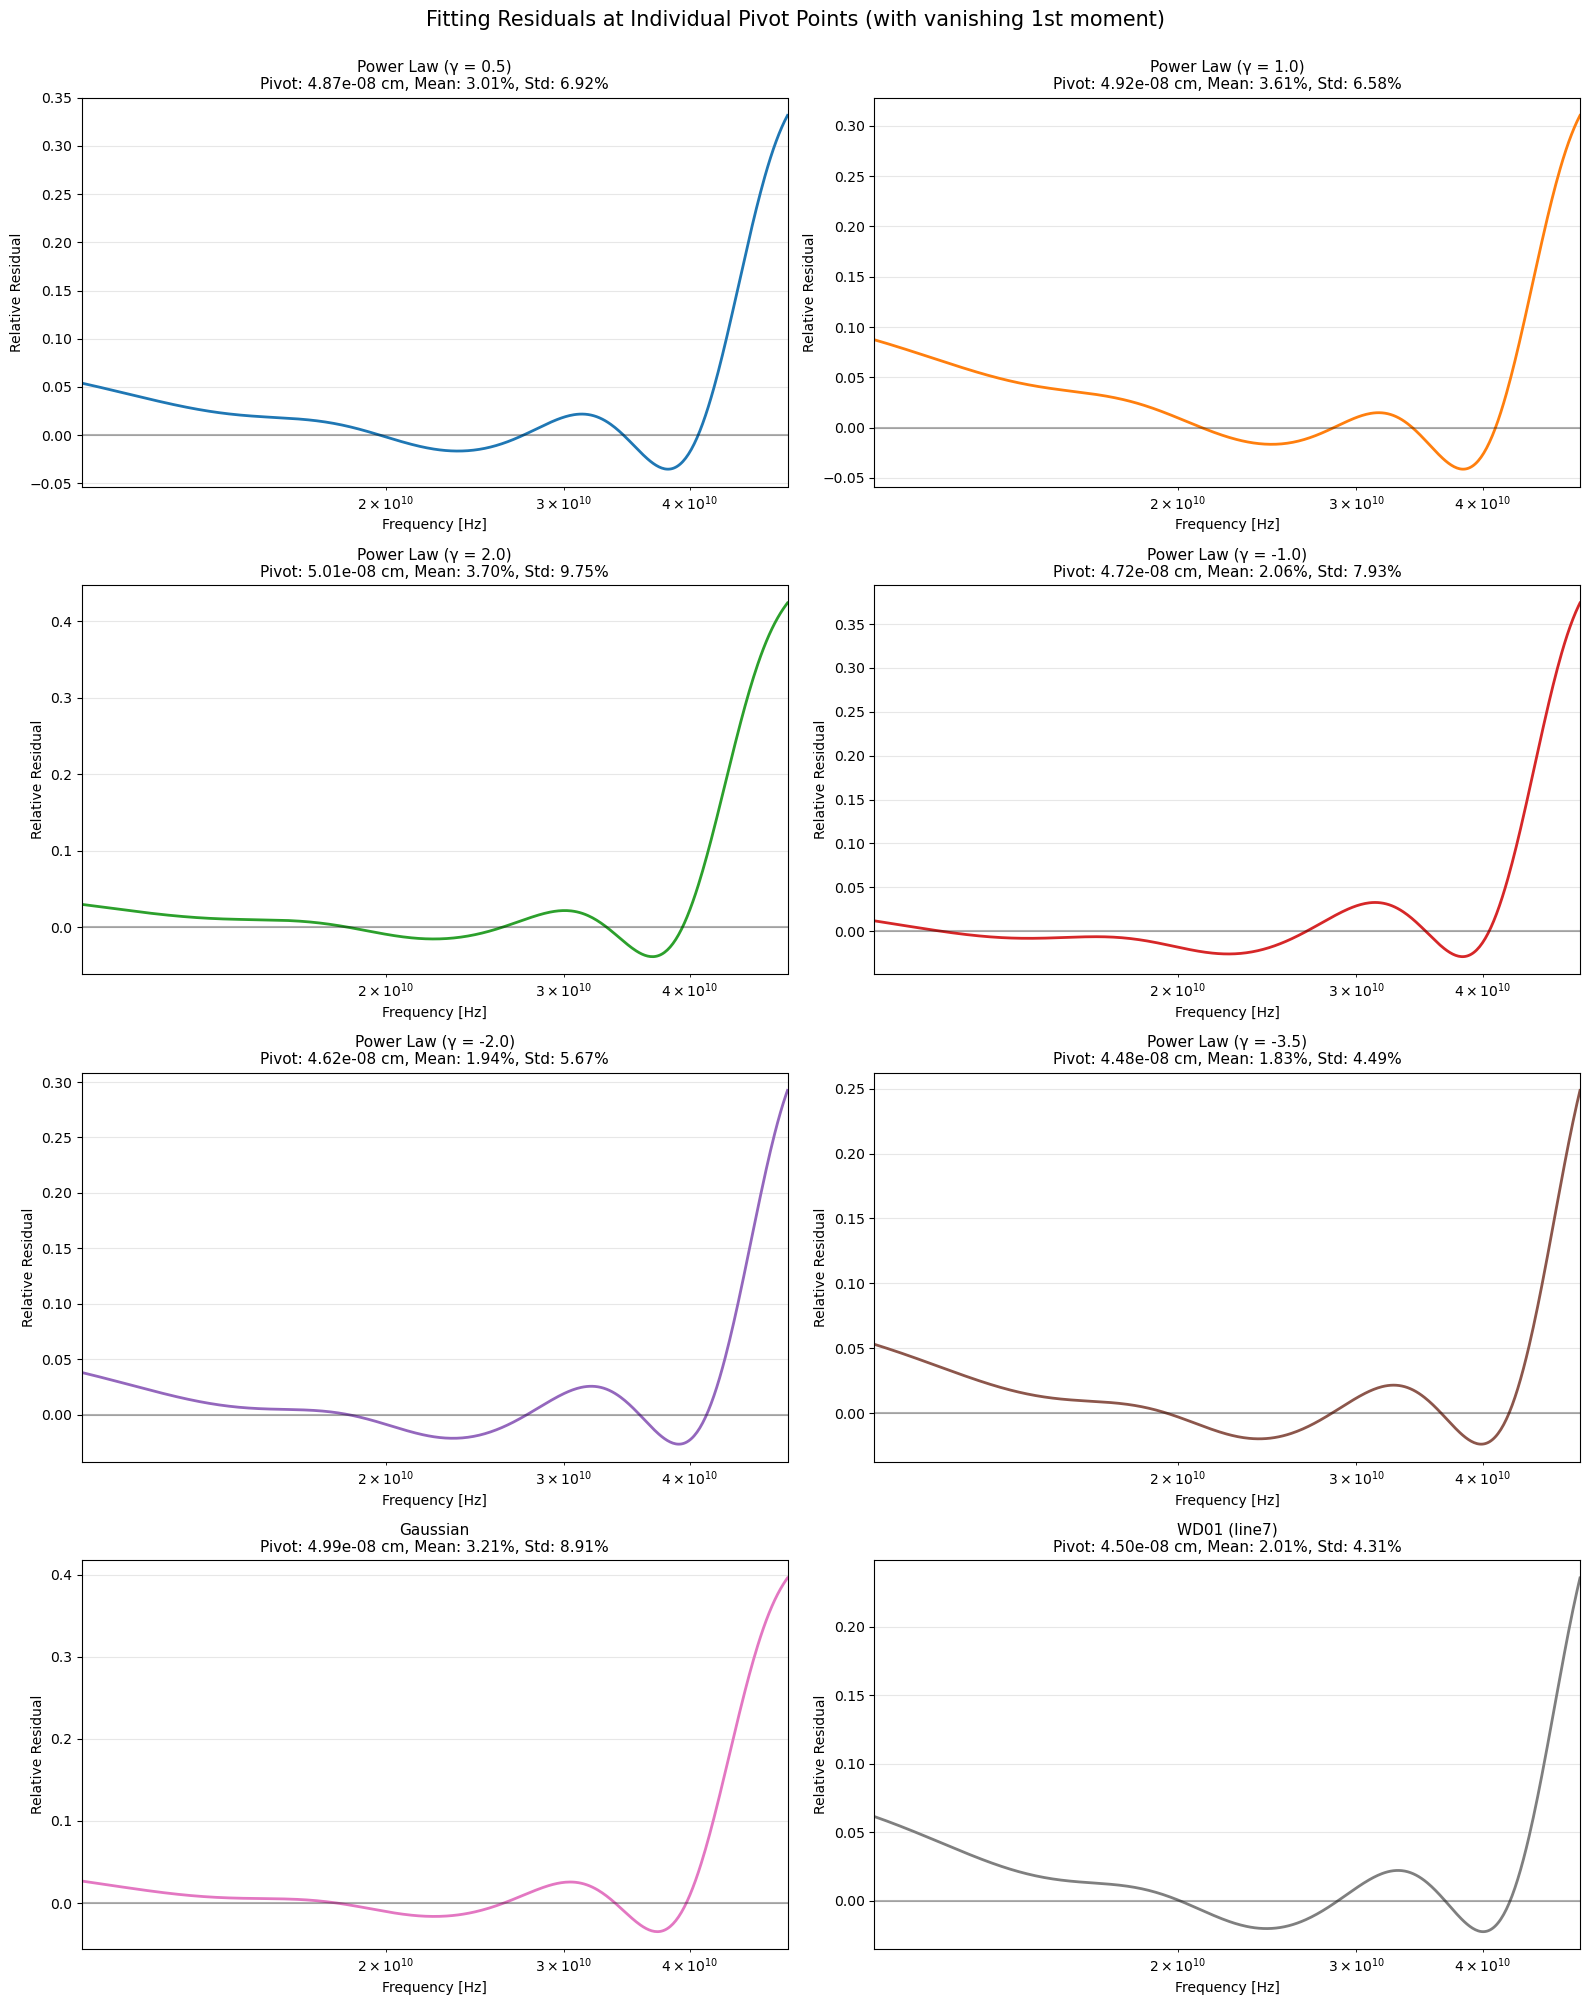

In [54]:
# Create figure comparing raw SEDs with fitted SEDs at their respective pivot points
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.suptitle('Raw vs Fitted SEDs using Derivative Basis at Individual Pivot Points (vanishing 1st moment)', fontsize=15, y=1.)

# Flatten axes for easier iteration
axes_flat = axes.flatten()

# Labels for the SEDs
sed_labels = ['Power Law (γ = 0.5)', 'Power Law (γ = 1.0)', 'Power Law (γ = 2.0)', 
              'Power Law (γ = -1.0)', 'Power Law (γ = -2.0)', 'Power Law (γ = -3.5)', 
              'Gaussian', 'WD01 (line7)']

# Colors for consistency
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

freq_hz = obs_omegas / (2 * np.pi)

# Plot each SED comparison
for i, (raw_sed, fitted_sed, residual, pivot, label, color) in enumerate(zip(
    SEDs_to_fit, SEDs_fitted_at_pivot, residuals_at_pivot, pivots_of_fit, sed_labels, colors)):
    
    ax = axes_flat[i]
    
    # Plot raw and fitted SEDs
    ax.loglog(freq_hz, raw_sed, '-', color=color, linewidth=2.5, label='Raw SED', alpha=0.8)
    ax.loglog(freq_hz, fitted_sed, '--', color='black', linewidth=2, label='Fitted SED', alpha=0.8)
    
    # Calculate fit quality metrics
    rel_error = np.abs(residual) / raw_sed
    mean_rel_error = np.mean(rel_error[raw_sed > 0])
    rms_residual = np.sqrt(np.mean(residual**2))
    
    # Set title with fit quality info and pivot point
    ax.set_title(f'{label}\nPivot: {pivot:.2e} cm, Mean Rel. Error: {mean_rel_error:.1%}', 
                fontsize=11)
    
    # Formatting
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('SED')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Set reasonable y-limits
    valid_sed = raw_sed[raw_sed > 0]
    if len(valid_sed) > 0:
        y_min = valid_sed.min() * 0.1
        y_max = max(valid_sed.max(), fitted_sed.max()) * 10
        ax.set_ylim(y_min, y_max)
    
    # Set x-limits
    ax.set_xlim(freq_hz.min(), freq_hz.max())

plt.tight_layout()
plt.show()

# Print summary statistics for pivot point fits
fit_type = "with vanishing 1st moment" if vanishing_1st_moment else "with all derivatives"
print(f"\nFITTING SUMMARY AT INDIVIDUAL PIVOT POINTS ({fit_type})")
print("="*80)
print(f"{'SED Type':<25} {'Pivot [cm]':<15} {'Mean Rel Error':<15} {'RMS Residual':<15}")
print("-"*80)

for i, (raw_sed, fitted_sed, residual, pivot, label) in enumerate(zip(
    SEDs_to_fit, SEDs_fitted_at_pivot, residuals_at_pivot, pivots_of_fit, sed_labels)):
    
    rel_error = np.abs(residual) / raw_sed
    mean_rel_error = np.mean(rel_error[raw_sed > 0])
    rms_residual = np.sqrt(np.mean(residual**2))
    
    print(f"{label:<25} {pivot:<15.2e} {mean_rel_error:<15.1%} {rms_residual:<15.2e}")

# Create a separate figure showing residuals for pivot fits
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.suptitle(f'Fitting Residuals at Individual Pivot Points ({fit_type})', fontsize=15, y=1.)

axes_flat = axes.flatten()

for i, (raw_sed, residual, pivot, label, color) in enumerate(zip(
    SEDs_to_fit, residuals_at_pivot, pivots_of_fit, sed_labels, colors)):
    
    ax = axes_flat[i]
    
    # Plot relative residuals
    rel_residual = residual / raw_sed
    ax.semilogx(freq_hz, rel_residual, color=color, linewidth=2)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Calculate residual statistics
    mean_rel_residual = np.mean(rel_residual)
    std_rel_residual = np.std(rel_residual)
    
    ax.set_title(f'{label}\nPivot: {pivot:.2e} cm, Mean: {mean_rel_residual:.2%}, Std: {std_rel_residual:.2%}', 
                fontsize=11)
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Relative Residual')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(freq_hz.min(), freq_hz.max())

plt.tight_layout()
plt.show()

## Fit at given point (the mid-point)

In [67]:
a_ref = (a_min + a2) / 2
basis_at_aref = generate_deri_SEDs(a_ref)

SEDs_fitted_at_aref = []
residuals_at_aref = []
for SED2fit in SEDs_to_fit:
    fitted_params, fitted_SED, residuals = linear_fit(a_ref, SED2fit, normalise=True, max_order=3, vanishing_1st_moment=False)
    SEDs_fitted_at_aref.append(fitted_SED)
    residuals_at_aref.append(residuals)

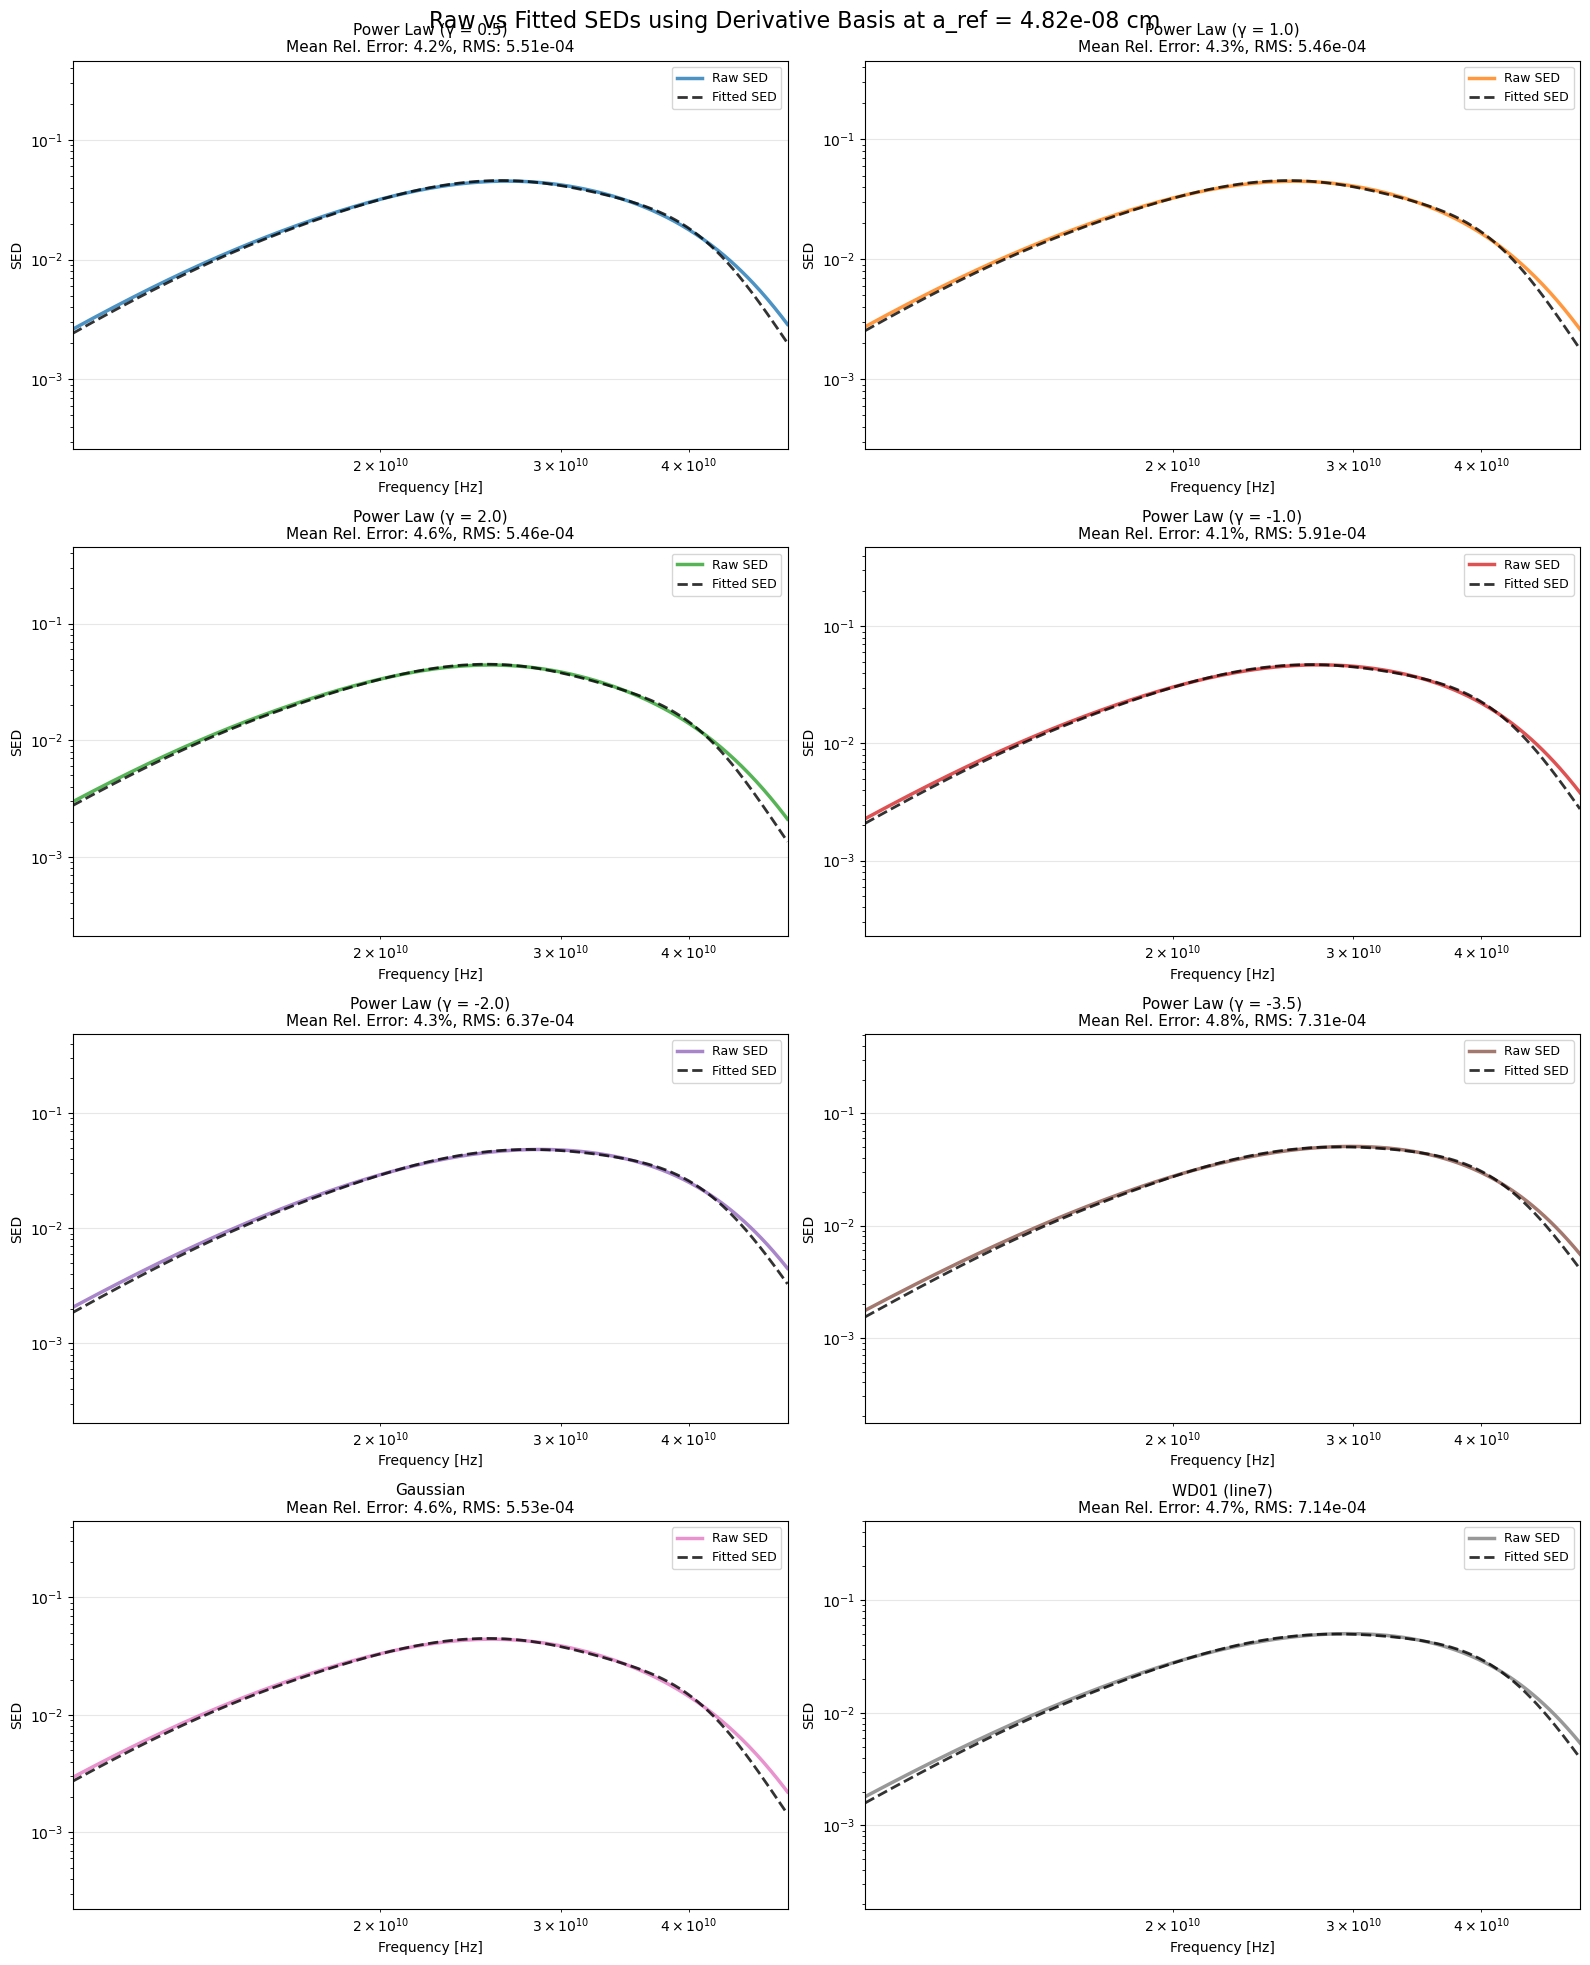


FITTING SUMMARY AT REFERENCE POINT a_ref = 4.818e-08 cm
SED Type                  Mean Rel Error  RMS Residual    Max Error      
----------------------------------------------------------------------
Power Law (γ = 0.5)       4.2%            5.51e-04        30.3%          
Power Law (γ = 1.0)       4.3%            5.46e-04        31.8%          
Power Law (γ = 2.0)       4.6%            5.46e-04        35.9%          
Power Law (γ = -1.0)      4.1%            5.91e-04        27.6%          
Power Law (γ = -2.0)      4.3%            6.37e-04        26.8%          
Power Law (γ = -3.5)      4.8%            7.31e-04        26.4%          
Gaussian                  4.6%            5.53e-04        35.3%          
WD01 (line7)              4.7%            7.14e-04        26.4%          


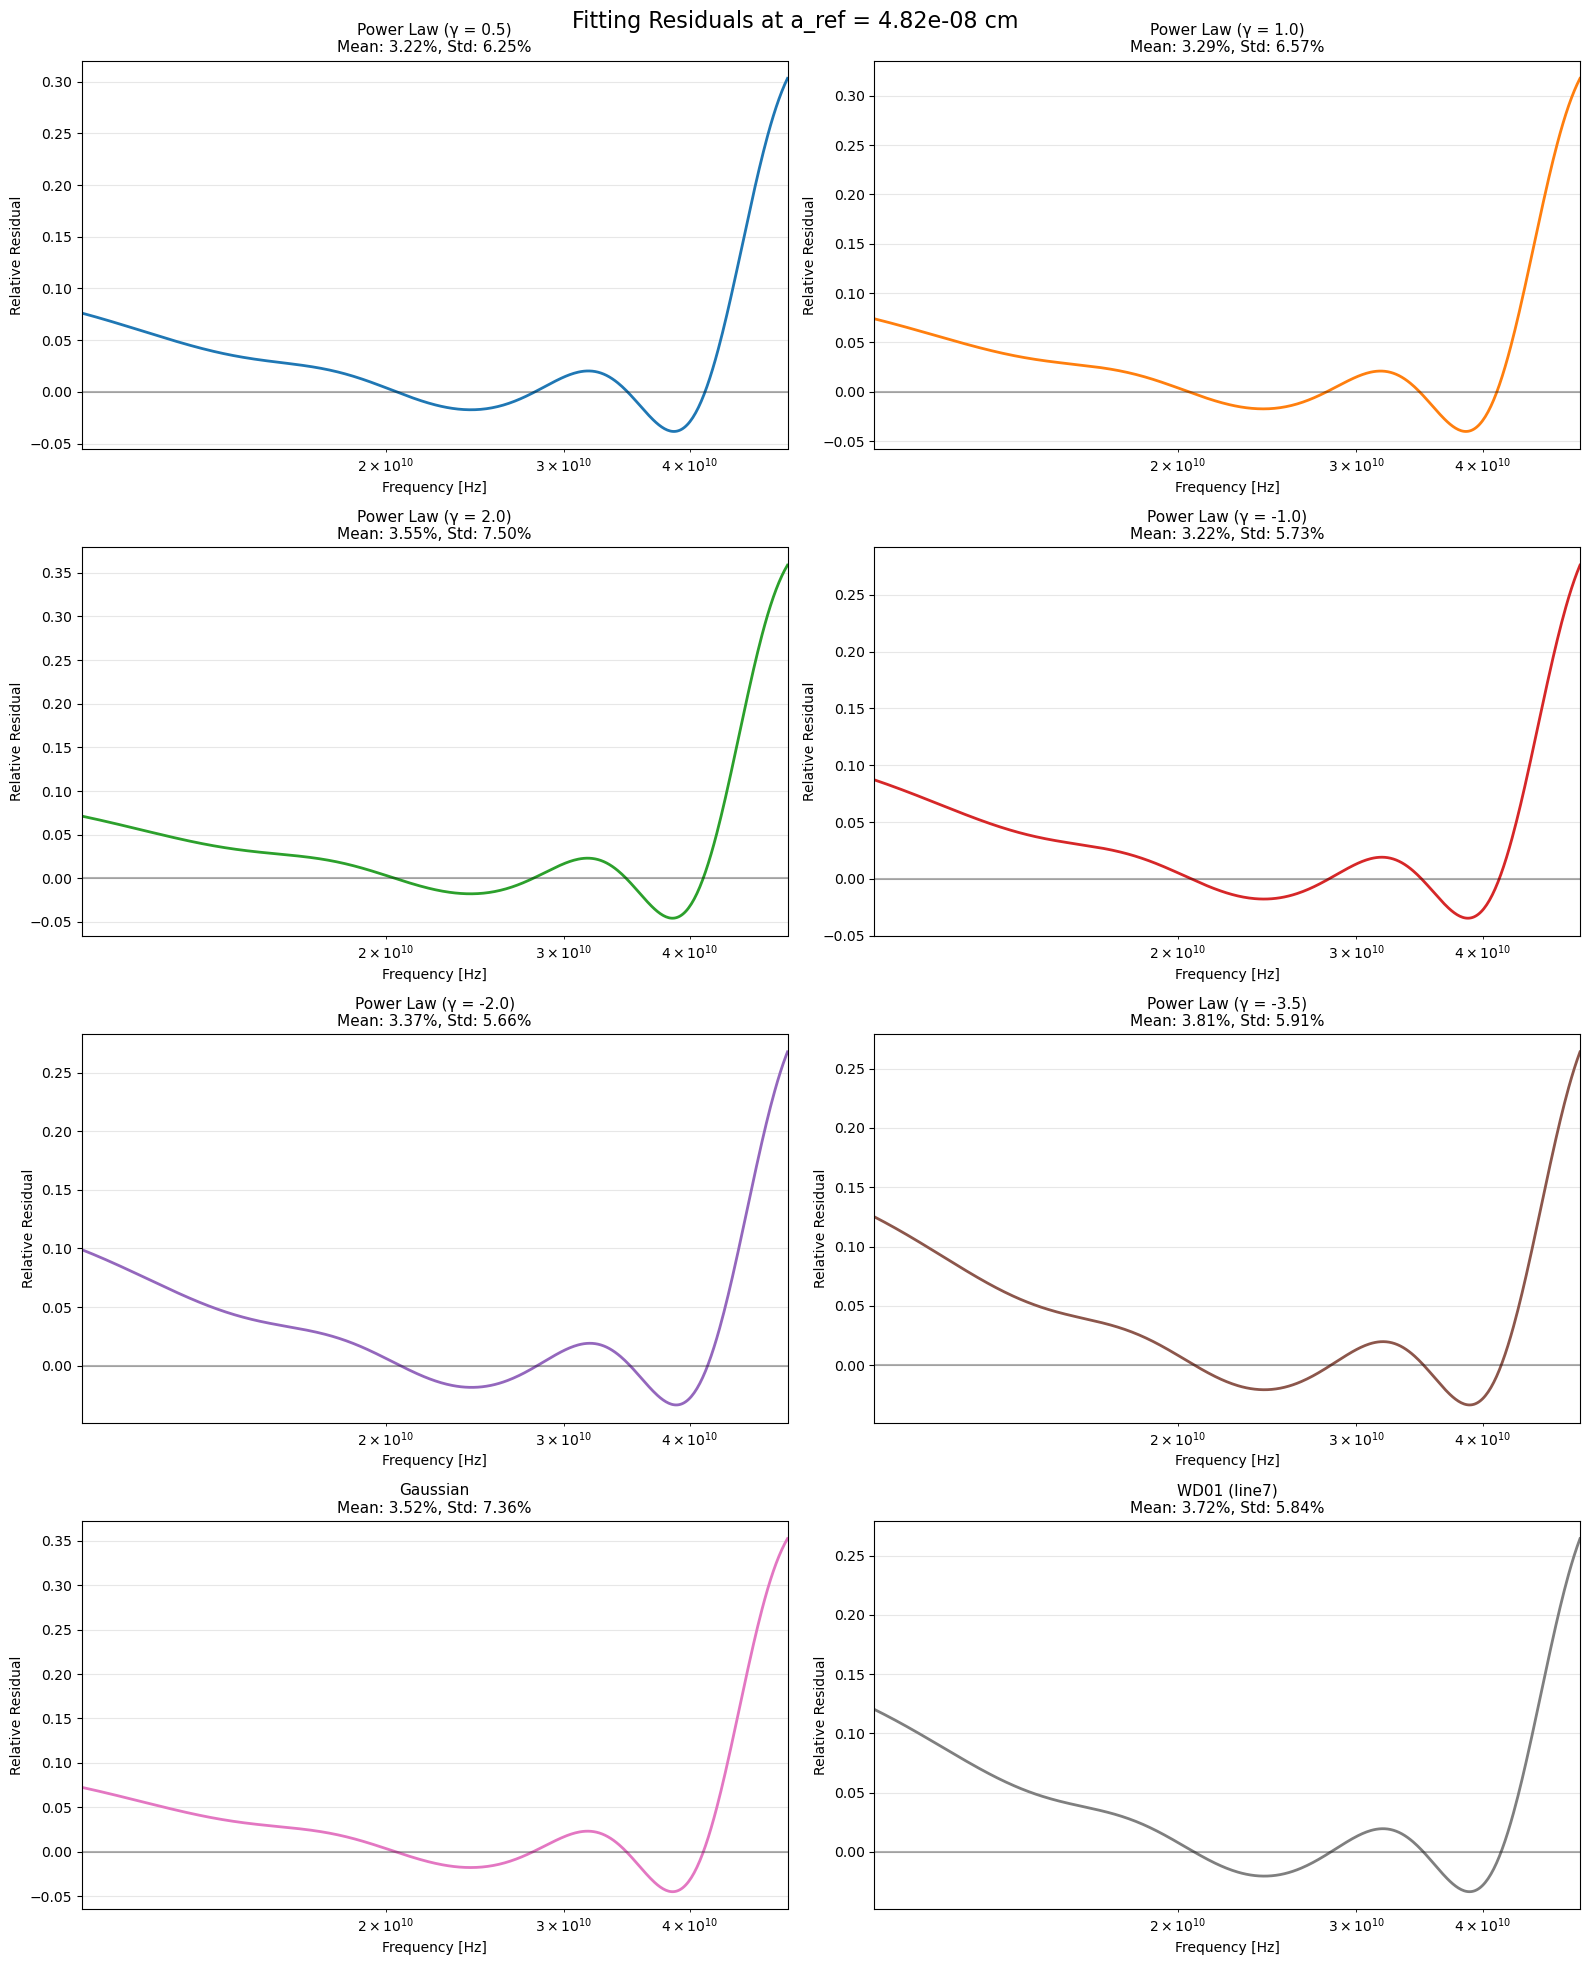

In [68]:
# Create figure comparing raw SEDs with fitted SEDs at reference point
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.suptitle(f'Raw vs Fitted SEDs using Derivative Basis at a_ref = {a_ref:.2e} cm', fontsize=16)

# Flatten axes for easier iteration
axes_flat = axes.flatten()

# Labels for the SEDs
sed_labels = ['Power Law (γ = 0.5)', 'Power Law (γ = 1.0)', 'Power Law (γ = 2.0)', 
              'Power Law (γ = -1.0)', 'Power Law (γ = -2.0)', 'Power Law (γ = -3.5)', 
              'Gaussian', 'WD01 (line7)']

# Colors for consistency
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

freq_hz = obs_omegas / (2 * np.pi)

# Plot each SED comparison
for i, (raw_sed, fitted_sed, residual, label, color) in enumerate(zip(
    SEDs_to_fit, SEDs_fitted_at_aref, residuals_at_aref, sed_labels, colors)):
    
    ax = axes_flat[i]
    
    # Plot raw and fitted SEDs
    ax.loglog(freq_hz, raw_sed, '-', color=color, linewidth=2.5, label='Raw SED', alpha=0.8)
    ax.loglog(freq_hz, fitted_sed, '--', color='black', linewidth=2, label='Fitted SED', alpha=0.8)
    
    # Calculate fit quality metrics
    rel_error = np.abs(residual) / raw_sed
    mean_rel_error = np.mean(rel_error[raw_sed > 0])
    rms_residual = np.sqrt(np.mean(residual**2))
    
    # Set title with fit quality info
    ax.set_title(f'{label}\nMean Rel. Error: {mean_rel_error:.1%}, RMS: {rms_residual:.2e}', 
                fontsize=11)
    
    # Formatting
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('SED')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Set reasonable y-limits
    valid_sed = raw_sed[raw_sed > 0]
    if len(valid_sed) > 0:
        y_min = valid_sed.min() * 0.1
        y_max = max(valid_sed.max(), fitted_sed.max()) * 10
        ax.set_ylim(y_min, y_max)
    
    # Set x-limits
    ax.set_xlim(freq_hz.min(), freq_hz.max())

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nFITTING SUMMARY AT REFERENCE POINT a_ref = {a_ref:.3e} cm")
print("="*70)
print(f"{'SED Type':<25} {'Mean Rel Error':<15} {'RMS Residual':<15} {'Max Error':<15}")
print("-"*70)

for i, (raw_sed, fitted_sed, residual, label) in enumerate(zip(
    SEDs_to_fit, SEDs_fitted_at_aref, residuals_at_aref, sed_labels)):
    
    rel_error = np.abs(residual) / raw_sed
    mean_rel_error = np.mean(rel_error[raw_sed > 0])
    rms_residual = np.sqrt(np.mean(residual**2))
    max_rel_error = np.max(rel_error[raw_sed > 0])
    
    print(f"{label:<25} {mean_rel_error:<15.1%} {rms_residual:<15.2e} {max_rel_error:<15.1%}")

# Create a separate figure showing residuals
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.suptitle(f'Fitting Residuals at a_ref = {a_ref:.2e} cm', fontsize=16)

axes_flat = axes.flatten()

for i, (raw_sed, residual, label, color) in enumerate(zip(
    SEDs_to_fit, residuals_at_aref, sed_labels, colors)):
    
    ax = axes_flat[i]
    
    # Plot relative residuals
    rel_residual = residual / raw_sed
    ax.semilogx(freq_hz, rel_residual, color=color, linewidth=2)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Calculate residual statistics
    mean_rel_residual = np.mean(rel_residual)
    std_rel_residual = np.std(rel_residual)
    
    ax.set_title(f'{label}\nMean: {mean_rel_residual:.2%}, Std: {std_rel_residual:.2%}', 
                fontsize=11)
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Relative Residual')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(freq_hz.min(), freq_hz.max())

plt.tight_layout()
plt.show()

In [ ]:
def log_normal_overall_SED(SED_size_list, a_dist_coeffs, weighted, 
                           save_path=None, threshold=1e-3,
                           title=''):
    SED_result = generate_synth_SED(SED_size_list, a_tab, a_dist_coeffs, weighted=weighted)
    fit_results = measure_sed_peak_properties(freqs, SED_result, plot=True, save_path=save_path, thres=threshold, title=title)
    peak_freq, sigma = fit_results['f_peak'], fit_results['sigma']
    return SED_result, peak_freq, sigma

# 1. thin disks, 
SED_size_list = SED_size_list_d

# - 1.1 Raw (spdust/spydust/WD01_line7) size distribution
a_dist_coeffs = grain_obj.a_dist
weighted = True

SED_d_raw, peak_d_raw, sigma_d_raw = log_normal_overall_SED(SED_size_list, a_dist_coeffs, weighted,
                                                            save_path='figures/SED_d_raw.pdf',
                                                            title='Raw size distribution\n')


# - 1.2 Power-law size distribution (gamma = -3.5)
pl_neg_dist = power_law_pdf(a_tab, gamma=-3.5)
a_dist_coeffs = pl_neg_dist
weighted = False

SED_d_pl, peak_d_pl, sigma_d_pl = log_normal_overall_SED(SED_size_list, a_dist_coeffs, weighted,
                                                            save_path='figures/SED_d_pl.pdf',
                                                            title='Power-law distribution (gamma = -3.5)\n')

# - 1.3 Log-normal size distribution (mu = np.log(a_tab).min())
mu_val = np.log(a_tab).min()
log_N_dist1 = log_normal_pdf(a_tab, mu=mu_val, sigma=0.4)
a_dist_coeffs = log_N_dist1
weighted = False

SED_d_ln_1, peak_d_ln_1, sigma_d_ln_1 = log_normal_overall_SED(SED_size_list, a_dist_coeffs, weighted,
                                                                save_path='figures/SED_d_ln_1.pdf',
                                                                title='Log-normal distribution (mu = min(grain size), sigma = 0.4)\n')

# - 1.4 Log-normal size distribution (mu = np.log(a_tab).max())
mu_val = np.log(a_tab).max()
log_N_dist2 = log_normal_pdf(a_tab, mu=mu_val, sigma=0.4)
a_dist_coeffs = log_N_dist2
weighted = False

SED_d_ln_2, peak_d_ln_2, sigma_d_ln_2 = log_normal_overall_SED(SED_size_list, a_dist_coeffs, weighted,
                                                                save_path='figures/SED_d_ln_2.pdf',
                                                                title='Log-normal distribution (mu = max(grain size), sigma = 0.4)\n')

# - 1.4 Log-normal size distribution (mu = (np.log(a_tab).min() + np.log(a_tab).max()) / 2)
mu_val = (np.log(a_tab).min() + np.log(a_tab).max()) / 2
log_N_dist3 = log_normal_pdf(a_tab, mu=mu_val, sigma=0.4)
a_dist_coeffs = log_N_dist3
weighted = False

SED_d_ln_3, peak_d_ln_3, sigma_d_ln_3 = log_normal_overall_SED(SED_size_list, a_dist_coeffs, weighted,
                                                                save_path='figures/SED_d_ln_3.pdf',
                                                                title='Log-normal distribution (mu = (min(grain size) + max(grain size)) / 2, sigma = 0.4)\n')

# - 1.4 Log-normal size distribution (mu = (np.log(a_tab).min() + np.log(a_tab).max()) / 2)
mu_val = (np.log(a_tab).min() + np.log(a_tab).max()) / 2
log_N_dist4 = log_normal_pdf(a_tab, mu=mu_val, sigma=0.2)
a_dist_coeffs = log_N_dist4
weighted = False

SED_d_ln_4, peak_d_ln_4, sigma_d_ln_4 = log_normal_overall_SED(SED_size_list, a_dist_coeffs, weighted,
                                                                save_path='figures/SED_d_ln_4.pdf',
                                                                title='Log-normal distribution (mu = (min(grain size) + max(grain size)) / 2, sigma = 0.2)\n')


In [ ]:
# 1. thin disks, 
SED_size_list = SED_size_list_2d

# - 1.1 Raw (spdust/spydust/WD01_line7) size distribution
a_dist_coeffs = grain_obj.a_dist
weighted = True

SED_2d_raw, peak_2d_raw, sigma_2d_raw = log_normal_overall_SED(SED_size_list, a_dist_coeffs, weighted,
                                                                save_path='figures/SED_2d_raw.pdf',
                                                                title='Raw size distribution (thicker)\n')


# - 1.2 Power-law size distribution (gamma = -3.5)
pl_neg_dist = power_law_pdf(a_tab, gamma=-3.5)
a_dist_coeffs = pl_neg_dist
weighted = False

SED_2d_pl, peak_2d_pl, sigma_2d_pl = log_normal_overall_SED(SED_size_list, a_dist_coeffs, weighted,
                                                            save_path='figures/SED_2d_pl.pdf',
                                                            title='Power-law distribution (thicker) (gamma = -3.5)\n')

# - 1.3 Log-normal size distribution (mu = np.log(a_tab).min())
mu_val = np.log(a_tab).min()
log_N_dist1 = log_normal_pdf(a_tab, mu=mu_val, sigma=0.4)
a_dist_coeffs = log_N_dist1
weighted = False

SED_2d_ln_1, peak_2d_ln_1, sigma_2d_ln_1 = log_normal_overall_SED(SED_size_list, a_dist_coeffs, weighted,
                                                                save_path='figures/SED_2d_ln_1.pdf',
                                                                title='Log-normal distribution (thicker) (mu = min(grain size), sigma = 0.4)\n')

# - 1.4 Log-normal size distribution (mu = np.log(a_tab).max())
mu_val = np.log(a_tab).max()
log_N_dist2 = log_normal_pdf(a_tab, mu=mu_val, sigma=0.4)
a_dist_coeffs = log_N_dist2
weighted = False

SED_2d_ln_2, peak_2d_ln_2, sigma_2d_ln_2 = log_normal_overall_SED(SED_size_list, a_dist_coeffs, weighted,
                                                                save_path='figures/SED_2d_ln_2.pdf',
                                                                title='Log-normal distribution (thicker) (mu = max(grain size), sigma = 0.4)\n')

# - 1.4 Log-normal size distribution (mu = (np.log(a_tab).min() + np.log(a_tab).max()) / 2)
mu_val = (np.log(a_tab).min() + np.log(a_tab).max()) / 2
log_N_dist3 = log_normal_pdf(a_tab, mu=mu_val, sigma=0.4)
a_dist_coeffs = log_N_dist3
weighted = False

SED_2d_ln_3, peak_2d_ln_3, sigma_2d_ln_3 = log_normal_overall_SED(SED_size_list, a_dist_coeffs, weighted,
                                                                save_path='figures/SED_2d_ln_3.pdf',
                                                                title='Log-normal distribution (thicker) (mu = (min(grain size) + max(grain size)) / 2, sigma = 0.4)\n')

# - 1.4 Log-normal size distribution (mu = (np.log(a_tab).min() + np.log(a_tab).max()) / 2)
mu_val = (np.log(a_tab).min() + np.log(a_tab).max()) / 2
log_N_dist4 = log_normal_pdf(a_tab, mu=mu_val, sigma=0.2)
a_dist_coeffs = log_N_dist4
weighted = False

SED_2d_ln_4, peak_2d_ln_4, sigma_2d_ln_4 = log_normal_overall_SED(SED_size_list, a_dist_coeffs, weighted, 
                                                                save_path='figures/SED_2d_ln_4.pdf',
                                                                title='Log-normal distribution (thicker) (mu = (min(grain size) + max(grain size)) / 2, sigma = 0.2)\n')


In [ ]:
# Plot the various grain size distributions
plt.figure(figsize=(12, 8))
ft_size = 14

def weight_dist(x):
    aux = x * a_tab
    return aux / np.sum(aux)

# Plot the raw distribution (from SpyDust/spdust)
plt.loglog(a_tab, grain_obj.a_dist, 'k-', linewidth=2, label='Raw distribution (SpyDust/spdust)')

# Plot the power-law distribution
plt.loglog(a_tab, weight_dist(pl_neg_dist), 'b--', linewidth=2, label='Power-law (γ = -3.5)')

# Plot the log-normal distributions
plt.loglog(a_tab, weight_dist(log_N_dist1), 'g:', linewidth=2, label=f'Log-normal (μ = {a_min:.2e}, σ = 0.4)')
plt.loglog(a_tab, weight_dist(log_N_dist2), 'm:', linewidth=2, label=f'Log-normal (μ = {a_max:.2e}, σ = 0.4)')
plt.loglog(a_tab, weight_dist(log_N_dist3), 'orange', linestyle=':', linewidth=2, label=f'Log-normal (μ = {a_mid:.2e}, σ = 0.4)')
plt.loglog(a_tab, weight_dist(log_N_dist4), 'brown', linestyle=':', linewidth=2, label=f'Log-normal (μ = {a_mid:.2e}, σ = 0.2)')

# Add vertical line to show the transition size a2
plt.axvline(x=a2, color='red', linestyle='-.', alpha=0.7, label=f'Transition size a₂ = {a2:.2e} cm')

# Add text boxes to label the regions
# Position text boxes at appropriate locations
disk_x_pos = a2 * 0.7  # Left of the transition line
spherical_x_pos = a2 * 3.0  # Right of the transition line
text_y_pos = 0.5  # Middle of the y-axis in log scale

# Add text boxes with background
plt.text(disk_x_pos, text_y_pos, 'Disk-like\ngrains', 
         fontsize=ft_size-2, ha='center', va='center',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))

plt.text(spherical_x_pos, text_y_pos, 'Spherical\ngrains', 
         fontsize=ft_size-2, ha='center', va='center',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8))

plt.xlabel('Grain size [cm]', fontsize=ft_size)
plt.ylabel('Normalized distribution', fontsize=ft_size)
plt.title('Grain Size Distributions', fontsize=ft_size+2)
plt.legend(fontsize=ft_size-2, loc='best')
plt.grid(True, alpha=0.3)
plt.tick_params(axis='both', which='major', labelsize=ft_size-2)

# Set reasonable axis limits
plt.xlim(a_tab.min() * 0.8, a_tab.max() * 1.2)
plt.ylim(1e-4, 1)

plt.tight_layout()
plt.savefig('figures/grain_size_distributions.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Set the figure size
plt.figure(figsize=(16, 12))

ft_size = 16
plt.scatter(a_disk, peak_disk_d, label=r'Disk grain; $d =3.35\times 10^{-8}$', marker='^')

plt.scatter(a_disk, peak_disk_2d, label=r'Thicker disk grain; $d =6.7\times 10^{-8}$', marker='x')

plt.scatter(a_sphere, peak_sphere, label=r'Spherical grain')

a_min = a_tab.min()
a_max = a_tab.max()
a_mid = (a_min + a_max) / 2

# Add horizontal lines for different grain size distributions
plt.axhline(y=peak_d_raw, color='red', linestyle='--', alpha=0.7, 
           label=f'Raw dist. ({peak_d_raw:.1f} GHz)')
plt.axhline(y=peak_2d_raw, color='red', linestyle='-.', alpha=0.7,
           label=f'Raw dist. (thicker diskgrain) ({peak_2d_raw:.1f} GHz)')

plt.axhline(y=peak_d_pl, color='blue', linestyle='--', alpha=0.7, 
           label=f'Power-law γ=-3.5 ({peak_d_pl:.1f} GHz)')
plt.axhline(y=peak_2d_pl, color='blue', linestyle='-.', alpha=0.7,
           label=f'Power-law γ=-3.5 (thicker diskgrain) ({peak_2d_pl:.1f} GHz)')

plt.axhline(y=peak_d_ln_1, color='green', linestyle='--', alpha=0.7, 
           label=f'Log-normal μ={a_min:.2e} ({peak_d_ln_1:.1f} GHz)')
plt.axhline(y=peak_2d_ln_1, color='green', linestyle='-.', alpha=0.7,
           label=f'Log-normal μ={a_min:.2e} (thicker diskgrain) ({peak_2d_ln_1:.1f} GHz)')

plt.axhline(y=peak_d_ln_2, color='purple', linestyle='--', alpha=0.7, 
           label=f'Log-normal μ={a_max:.2e} σ=0.4({peak_d_ln_2:.1f} GHz)')
plt.axhline(y=peak_2d_ln_2, color='purple', linestyle='-.', alpha=0.7,
           label=f'Log-normal μ={a_max:.2e} σ=0.4 (thicker diskgrain) ({peak_2d_ln_2:.1f} GHz)')

plt.axhline(y=peak_d_ln_3, color='orange', linestyle='--', alpha=0.7, 
           label=f'Log-normal μ={a_mid:.2e} σ=0.4 ({peak_d_ln_3:.1f} GHz)')
plt.axhline(y=peak_2d_ln_3, color='orange', linestyle='-.', alpha=0.7,
           label=f'Log-normal μ={a_mid:.2e} σ=0.4 (thicker diskgrain) ({peak_2d_ln_3:.1f} GHz)')

plt.axhline(y=peak_d_ln_4, color='brown', linestyle='--', alpha=0.7, 
           label=f'Log-normal μ={a_mid:.2e} σ=0.2 ({peak_d_ln_4:.1f} GHz)')
plt.axhline(y=peak_2d_ln_4, color='brown', linestyle='-.', alpha=0.7,
           label=f'Log-normal μ={a_mid:.2e} σ=0.2 (thicker diskgrain) ({peak_2d_ln_4:.1f} GHz)')

plt.title('Peak Frequency vs Grain Size', fontsize=ft_size)

plt.ylabel('Peak Frequency [GHz]', fontsize=ft_size)
plt.xlabel('Grain size [cm]', fontsize=ft_size)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=ft_size)
# tick label sizes
plt.xticks(fontsize=ft_size-2)
plt.yticks(fontsize=ft_size-2)
plt.tight_layout()
plt.savefig('figures/peak_freq_vs_grain_size.pdf')

In [ ]:
# Set the figure size
plt.figure(figsize=(16, 12))
ft_size = 16

plt.scatter(a_disk, sigma_disk_d, label=r'Disk grain; $d =3.35\times 10^{-8}$', marker='^')

plt.scatter(a_disk, sigma_disk_2d, label=r'Thicker disk grain; $d =6.7\times 10^{-8}$', marker='x')

plt.scatter(a_sphere, sigma_sphere, label=r'Spherical grain')

plt.axhline(y=sigma_d_raw, color='red', linestyle='--', alpha=0.7, 
           label=f'Raw dist. (width={sigma_d_raw:.2f})')
plt.axhline(y=sigma_2d_raw, color='red', linestyle='-.', alpha=0.7,
           label=f'Raw dist. (thicker diskgrain) (width={sigma_2d_raw:.2f})')

plt.axhline(y=sigma_d_pl, color='blue', linestyle='--', alpha=0.7, 
           label=f'Power-law γ=-3.5 (width={sigma_d_pl:.2f})')
plt.axhline(y=sigma_2d_pl, color='blue', linestyle='-.', alpha=0.7,
           label=f'Power-law γ=-3.5 (thicker diskgrain) (width={sigma_2d_pl:.2f})')

plt.axhline(y=sigma_d_ln_1, color='green', linestyle='--', alpha=0.7, 
            label=f'Log-normal μ={a_min:.2e} σ=0.4 (width={sigma_d_ln_1:.2f})')
plt.axhline(y=sigma_2d_ln_1, color='green', linestyle='-.', alpha=0.7,
            label=f'Log-normal μ={a_min:.2e} σ=0.4 (thicker diskgrain) (width={sigma_2d_ln_1:.2f})')

plt.axhline(y=sigma_d_ln_2, color='purple', linestyle='--', alpha=0.7, 
            label=f'Log-normal μ={a_max:.2e} σ=0.4 (width={sigma_d_ln_2:.2f})')
plt.axhline(y=sigma_2d_ln_2, color='purple', linestyle='-.', alpha=0.7,
            label=f'Log-normal μ={a_max:.2e} σ=0.4 (thicker diskgrain) (width={sigma_2d_ln_2:.2f})')

plt.axhline(y=sigma_d_ln_3, color='orange', linestyle='--', alpha=0.7, 
            label=f'Log-normal μ={a_mid:.2e} σ=0.4 (width={sigma_d_ln_3:.2f})')
plt.axhline(y=sigma_2d_ln_3, color='orange', linestyle='-.', alpha=0.7,
            label=f'Log-normal μ={a_mid:.2e} σ=0.4 (thicker diskgrain) (width={sigma_2d_ln_3:.2f})')

plt.axhline(y=sigma_d_ln_4, color='brown', linestyle='--', alpha=0.7, 
            label=f'Log-normal μ={a_mid:.2e} σ=0.2 (width={sigma_d_ln_4:.2f})')
plt.axhline(y=sigma_2d_ln_4, color='brown', linestyle='-.', alpha=0.7,
            label=f'Log-normal μ={a_mid:.2e} σ=0.2 (thicker diskgrain) (width={sigma_2d_ln_4:.2f})')

plt.ylabel('Lognormal Width [GHz]', fontsize=ft_size)
plt.xlabel('Grain size [cm]', fontsize=ft_size)
plt.title('Lognormal Width vs Grain Size', fontsize=ft_size)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=ft_size)
plt.xticks(fontsize=ft_size-2)
plt.yticks(fontsize=ft_size-2)
plt.savefig('figures/lognormal_width_vs_grain_size.pdf', dpi=300)

In [ ]:
import os



def combine_pdfs_to_panels(pdf_files, rows, cols, figsize=(16, 12), 
                          output_file=None, 
                          titles=None, suptitle=None, dpi=300, 
                          common_xlabel=None, common_ylabel=None, 
                          add_panel_labels=True, panel_label_fontsize=16,
                          ay=1., by=0., ly=0.0,
                          ax=1., bx=0., lx=0.0):
    """
    Combine multiple PDF files into a single PDF with panels arranged in rows and columns.
    
    Parameters:
    -----------
    pdf_files : list of str
        List of PDF file paths to combine
    output_file : str
        Output PDF file path
    rows : int
        Number of rows in the panel layout
    cols : int
        Number of columns in the panel layout
    figsize : tuple
        Figure size (width, height) in inches
    titles : list of str, optional
        List of titles for each panel
    suptitle : str, optional
        Main title for the entire figure
    dpi : int
        DPI for the output PDF
    common_xlabel : str, optional
        Common x-axis label for all panels
    common_ylabel : str, optional
        Common y-axis label for all panels
    label_fontsize : int
        Font size for common axis labels
    add_panel_labels : bool
        Whether to add panel labels (a, b, c, etc.)
    panel_label_fontsize : int
        Font size for panel labels
    """
    
    # Verify we have the right number of files
    expected_panels = rows * cols
    if len(pdf_files) != expected_panels:
        raise ValueError(f"Expected {expected_panels} PDF files for {rows}x{cols} layout, got {len(pdf_files)}")
    
    # Convert PDFs to images first (using pdf2image library)
    try:
        from pdf2image import convert_from_path
    except ImportError:
        raise ImportError("Please install pdf2image: pip install pdf2image")
    
    # Create the combined figure
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1 or cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    # Process each PDF file
    for i, pdf_file in enumerate(pdf_files):
        if not os.path.exists(pdf_file):
            print(f"Warning: File {pdf_file} not found, skipping...")
            continue
            
        # Convert PDF to image
        try:
            images = convert_from_path(pdf_file, dpi=200, first_page=1, last_page=1)
            img_array = np.array(images[0])
            
            # Display the image
            axes[i].imshow(img_array)
            axes[i].axis('off')
            
            # Add title if provided
            if titles and i < len(titles) and titles[i]:
                axes[i].set_title(titles[i], fontsize=12, pad=10)
                
        except Exception as e:
            print(f"Error processing {pdf_file}: {e}")
            axes[i].text(0.5, 0.5, f"Error loading\n{os.path.basename(pdf_file)}", 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    # Hide any unused subplots
    for i in range(len(pdf_files), len(axes)):
        axes[i].axis('off')
    
    # Add main title if provided
    if suptitle:
        fig.suptitle(suptitle, fontsize=16, y=0.95)
    
    # Adjust layout to make room for common labels and panel labels
    plt.tight_layout()
    if suptitle:
        plt.subplots_adjust(top=0.9)
    
    # Adjust margins for labels
    left_margin = 0.08 if common_ylabel else 0.05
    bottom_margin = 0.08 if common_xlabel else 0.05
    
    # Extra space for panel labels
    if add_panel_labels:
        left_margin += 0.03  # Extra space for row labels
        bottom_margin += 0.03  # Extra space for column labels
    
    plt.subplots_adjust(left=left_margin, bottom=bottom_margin)
    
    # Add common axis labels
    # if common_xlabel:
    #     fig.text(0.5, 0.02, common_xlabel, ha='center', va='bottom', 
    #             fontsize=label_fontsize, weight='bold')
    
    # if common_ylabel:
    #     fig.text(0.02, 0.5, common_ylabel, ha='center', va='center', 
    #             rotation='vertical', fontsize=label_fontsize, weight='bold')
    
    # Add panel labels
    if add_panel_labels:
        
        # Row labels  
        row_labels = [common_ylabel] * rows  # Use common x-label as row label
        for i, label in enumerate(row_labels):
            y_pos =ay *( 1 - (i + 0.5) / rows ) + by # Center vertically for each row
            fig.text(left_margin - ly, y_pos, f'{label}', 
                    ha='center', va='center', 
                    fontsize=panel_label_fontsize, weight='bold', rotation='vertical')
        
        # Column labels (bottom edge) - numbers: 1, 2, 3, ... or letters
        col_labels = [common_xlabel] * cols  # Use common y-label as column label

        
        for j, label in enumerate(col_labels):
            x_pos = ax * ((j + 0.5) / cols) + bx  # Center horizontally for each column
            fig.text(x_pos, bottom_margin - lx, f'{label}', 
                    ha='center', va='center', 
                    fontsize=panel_label_fontsize, weight='bold')
    
    # Save the combined figure
    if output_file is not None:
        plt.savefig(output_file, dpi=dpi, bbox_inches='tight', pad_inches=0.1)
    plt.show()

    pass


In [ ]:
list_pdfs = [
    "figures/discSED_d_0.pdf",
    "figures/discSED_2d_0.pdf",
    "figures/discSED_d_1.pdf", 
    "figures/discSED_2d_1.pdf", 
    "figures/discSED_d_2.pdf",
    "figures/discSED_2d_2.pdf",
    "figures/discSED_d_3.pdf",
    "figures/discSED_2d_3.pdf",
    "figures/discSED_d_4.pdf",
    "figures/discSED_2d_4.pdf",
    "figures/discSED_d_5.pdf",
    "figures/discSED_2d_5.pdf",
    "figures/discSED_d_6.pdf",
    "figures/discSED_2d_6.pdf"
]

# panel_titles = [
#     "1×TOD; 1 CalSrc",
#     "2×TOD; 1 CalSrc",
#     "1×TOD; 5 CalSrc", 
#     "2×TOD; 5 CalSrc",
#     "1×TOD; 5 CalSrc + 1/f prior",
#     "2×TOD; 5 CalSrc + 1/f prior"
# ]

panel_titles = None

combine_pdfs_to_panels(
    pdf_files=list_pdfs,
    output_file="figures/combined_disk_SED.pdf",
    rows=7, cols=2,
    titles=None,
    # common_xlabel=r'$T_{\mathrm{residual}} = \langle T^{\mathrm{sample}}_{\mathrm{sky}} \rangle - T_{\mathrm{sky}}^{\mathrm{true}}$ [K]',
    # common_ylabel="Probability Density",
    figsize=(16, 28),
    add_panel_labels=False,  # Enable panel labels
    panel_label_fontsize=13,
    ay=0.9, by=0.1, ly=0.01,
    ax=0.9, bx=0.1, lx=0.02,
)

In [ ]:
list_pdfs = [
    "figures/sphSED_d_0.pdf",
    "figures/sphSED_d_1.pdf", 
    "figures/sphSED_d_2.pdf",
    "figures/sphSED_d_3.pdf",
    "figures/sphSED_d_4.pdf",
    "figures/sphSED_d_5.pdf",
    "figures/sphSED_d_6.pdf"
]

# panel_titles = [
#     "1×TOD; 1 CalSrc",
#     "2×TOD; 1 CalSrc",
#     "1×TOD; 5 CalSrc", 
#     "2×TOD; 5 CalSrc",
#     "1×TOD; 5 CalSrc + 1/f prior",
#     "2×TOD; 5 CalSrc + 1/f prior"
# ]

panel_titles = None

combine_pdfs_to_panels(
    pdf_files=list_pdfs,
    output_file="figures/combined_spherical_SED.pdf",
    rows=7, cols=1,
    titles=None,
    # common_xlabel=r'$T_{\mathrm{residual}} = \langle T^{\mathrm{sample}}_{\mathrm{sky}} \rangle - T_{\mathrm{sky}}^{\mathrm{true}}$ [K]',
    # common_ylabel="Probability Density",
    figsize=(16, 14),
    add_panel_labels=False,  # Enable panel labels
    panel_label_fontsize=13,
    ay=0.9, by=0.1, ly=0.01,
    ax=0.9, bx=0.1, lx=0.02,
)

In [ ]:
list_pdfs = [
    "figures/SED_d_raw.pdf",
    "figures/SED_2d_raw.pdf",
    "figures/SED_d_pl.pdf",
    "figures/SED_2d_pl.pdf",
    "figures/SED_d_ln_1.pdf",
    "figures/SED_2d_ln_1.pdf",
    "figures/SED_d_ln_2.pdf",
    "figures/SED_2d_ln_2.pdf",
    "figures/SED_d_ln_3.pdf",
    "figures/SED_2d_ln_3.pdf",
    "figures/SED_d_ln_4.pdf",
    "figures/SED_2d_ln_4.pdf"
]

# panel_titles = [
#     "1×TOD; 1 CalSrc",
#     "2×TOD; 1 CalSrc",
#     "1×TOD; 5 CalSrc", 
#     "2×TOD; 5 CalSrc",
#     "1×TOD; 5 CalSrc + 1/f prior",
#     "2×TOD; 5 CalSrc + 1/f prior"
# ]

panel_titles = None

combine_pdfs_to_panels(
    pdf_files=list_pdfs,
    output_file="figures/combined_overall_SED.pdf",
    rows=6, cols=2,
    titles=None,
    # common_xlabel=r'$T_{\mathrm{residual}} = \langle T^{\mathrm{sample}}_{\mathrm{sky}} \rangle - T_{\mathrm{sky}}^{\mathrm{true}}$ [K]',
    # common_ylabel="Probability Density",
    figsize=(14, 28),
    add_panel_labels=False,  # Enable panel labels
    panel_label_fontsize=13,
    ay=0.9, by=0.1, ly=0.01,
    ax=0.9, bx=0.1, lx=0.02,
)